# Measure Transport with KSD

In [253]:
import matplotlib.pyplot as plt
import sklearn.datasets as datasets
import numpy as np

import torch
from torch import nn
from torch import optim

from nflows.flows.base import Flow
from nflows.distributions.normal import StandardNormal
from nflows.transforms.base import CompositeTransform

plt.rcParams['figure.figsize'] = [12,12]

Let $Q$ be our reference distribution and $P$ our target distribution. Measure transport (or Normalising flows) can be split into two distinct categories:
- Variational inference: where the target measure $P$ is approximated using its (unnormalised) density. In this case one constructs a flow object `Flow` which pushes forward samples from $Q$ to $P$. The parameters in `Flow` are fitted via a stochastic optimisation method using a discrepancy (KSD or KL divergence) using samples from $Q$.
- Density estimation: where the target measure $P$ is approximated using samples from $P$. In this case one constructs an invertible flow object `Flow` which pushes forward samples from $P$ to $Q$. The parameters in `Flow` are determined using a discrepancy (KSD or KL divergence) using samples from $P$.


## Defining KSD loss function

Recall that KSD can be approximated as
$$ \mathbb{S}_P(Q) \approx \sum_{i=1}^n\sum_{j=1}^n u_p(x_i,x_j),$$

where $\{x_i\}_{i=1}^n$ is a sample from $Q$ and 

$$ u_p(x,y) = s_p(x)^\top k(x,y) s_p(y) + s_p(x)^\top \nabla_yk(x,y) + \nabla_xk(x,y)s_p(x) + \text{trace}(\nabla_x\cdot\nabla_yk(x,y)).$$

We define the KSD for the inverse multiquadric kernel:

In [20]:
l2 = nn.PairwiseDistance(2)

def loss_KSD(samples,score_func):
    N = samples.size()[0]
    d = samples[0].size()[0] #dimension of tensor
        
    scores = score_func(samples)
    s1 = scores.repeat(1,N).view(N*N,2)
    s2 = scores.repeat(N,1)
    
    samps1 = samples.repeat(1,N).view(N*N,2)
    samps2 = samples.repeat(N,1)

    diffs = samps1 - samps2
    dists = l2(samps1,samps2)**2

    k = (1 + dists)**(-1/2)
    k_x = -(1 + dists[:,None])**(-3/2)*diffs
    k_y = -k_x
    k_xy = -3*dists*(1 + dists)**(-5/2) + d*(1 + dists)**(-3/2)
    
    outvec = k*torch.sum(s1*s2,dim=-1) + torch.sum(s1*k_y,dim=-1) + torch.sum(s2*k_x,dim=-1) + k_xy
    output = torch.mean(outvec)
    
    return output

## Defining test score functions

A flexible parameterisation of densities are Energy Based Models (EBMs), where

$$ p(x) \propto \exp(-E(x)), $$

where $E$ is some energy function (assuming that $\int \exp(-E(x))\,\mathrm{d}x$ is finite). In this case, the score function is of the form

$$ s(x) = -\nabla E(x). $$

### Standard Normal

In [6]:
def score_standard_norm(x):
    return -x

### Mixture of Gaussians

The following Mixture Of Gaussians (MOG) score function assumes uniform weights and identity covariance matrices.

In [243]:
#assuming identity covariance matrix

def score_mixture_gauss(x, MOG):

    p_0 = torch.exp(MOG[0].log_prob(x))
    x_0 = -(x - MOG[0].mean)

    output = x_0 * p_0[:,None]
    
    for i in range(len(MOG)-1):
        p_i = torch.exp(MOG[i+1].log_prob(x))
        x_i = - (x - MOG[i+1].mean)
        output = output + x_i * p_i[:,None]
        p_0 = p_0 + p_i
        
    output = output / p_0[:, None]
    return output


In [248]:
m1 = torch.Tensor([2,2])
g1 = torch.distributions.multivariate_normal.MultivariateNormal(m1,torch.eye(2))

m2 = torch.Tensor([0,-1])
g2 = torch.distributions.multivariate_normal.MultivariateNormal(m2,torch.eye(2))

MOG_example = [g1,g2]

score_mix_example = lambda x: score_mixture_gauss(x,MOG_example)

In [420]:
def plot_MOG(MOG):
    xline = torch.linspace(-5, 5)
    yline = torch.linspace(-5, 5)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        n = len(MOG)
        zgrid = 1/n*MOG[0].log_prob(xyinput).exp().reshape(100, 100)
        for i in range(n-1):
            zgrid = zgrid + 1/n*MOG[i+1].log_prob(xyinput).exp().reshape(100, 100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())

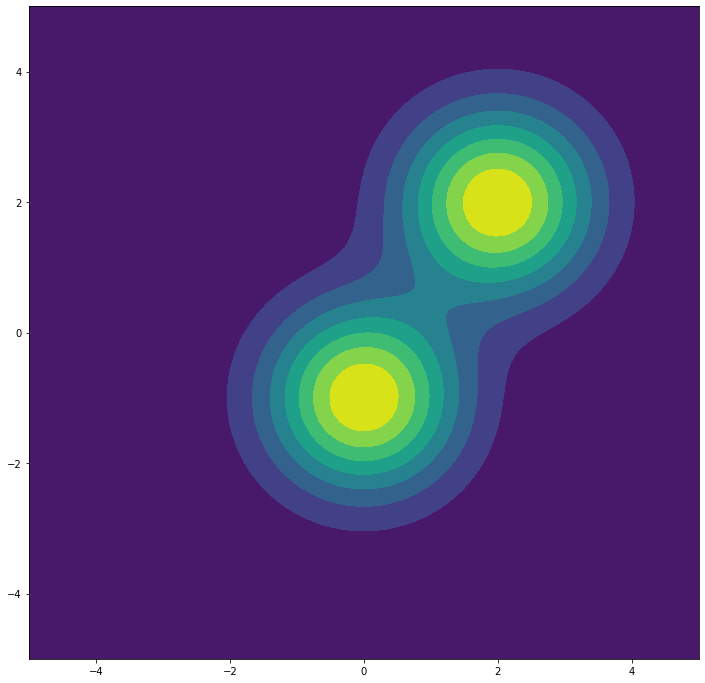

In [421]:
plot_MOG(MOG_example)

### Tensor product of Gumbel distribution

In [213]:
def score_gumbel(x):
    return torch.exp(-x) - 1

In [44]:
def weird_score(x):
    return -x*(1 +torch.sin(x))

### 2D Banana distribution

Banana density of the form

$$ p(x_1,x_2) = \mathcal{N}(x_1;0,v_1)\mathcal{N}(x_2;ax_1^2,v_2), $$

where $\mathcal{N}(x;\mu,\sigma^2)$ is one-dimensional Gaussian distribution with mean $\mu$ and variance $\sigma^2$.

In [383]:
a1 = torch.Tensor([1,2,3,4])
a2  = torch.Tensor([4,3,2,1])

torch.stack((a1,a2)).t()

tensor([[1., 4.],
        [2., 3.],
        [3., 2.],
        [4., 1.]])

In [386]:
def score_banana(x,a,v1,v2):
    x2,x1 = x.t()
    dx1 = -x1/v1 + 2*a*x1*(x2-a*x1**2)/v2
    dx2 = -(x2-a*x1**2)/v2
    return torch.stack((dx1,dx2)).t()

In [367]:
a = 1
v1 = 1.5
v2 = 1.5

score_banana_example = lambda x: score_banana(x,a,v1,v2)

In [401]:
def plot_banana(a,v1,v2):
    xline = torch.linspace(-8, 8)
    yline = torch.linspace(-8, 8)
    xgrid, ygrid = torch.meshgrid(xline, yline)
    xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

    with torch.no_grad():
        n = np.pi*2
        out1 = (xyinput*torch.Tensor([[0,1]]))**2/v1
        out2 = xyinput*torch.Tensor([[1,0]])/v2
        zgrid = 1/n*torch.exp(-(1/2)*(torch.sum(out1,dim=-1) + torch.sum(out2-a*out1,dim=-1)**2)).reshape(100,100)

    plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())

## Density estimation with KL divergence

In [433]:
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

iteration: 50, loss: tensor(5.4439, grad_fn=<NegBackward>)
iteration: 100, loss: tensor(3.7322, grad_fn=<NegBackward>)
iteration: 150, loss: tensor(2.2305, grad_fn=<NegBackward>)
iteration: 200, loss: tensor(1.9744, grad_fn=<NegBackward>)
iteration: 250, loss: tensor(1.8731, grad_fn=<NegBackward>)
iteration: 300, loss: tensor(1.8022, grad_fn=<NegBackward>)
iteration: 350, loss: tensor(1.7493, grad_fn=<NegBackward>)
iteration: 400, loss: tensor(1.7341, grad_fn=<NegBackward>)
iteration: 450, loss: tensor(1.7265, grad_fn=<NegBackward>)
iteration: 500, loss: tensor(1.7468, grad_fn=<NegBackward>)


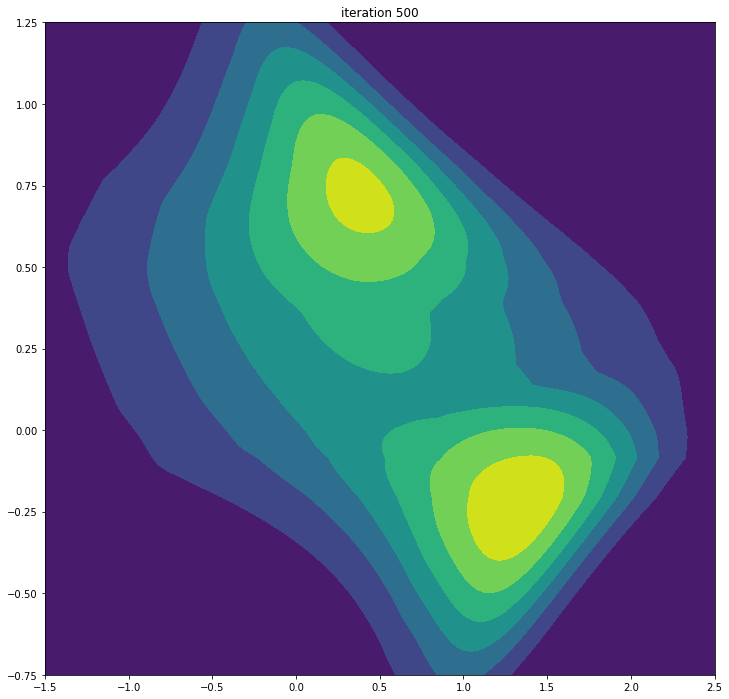

iteration: 550, loss: tensor(1.7294, grad_fn=<NegBackward>)
iteration: 600, loss: tensor(1.7052, grad_fn=<NegBackward>)
iteration: 650, loss: tensor(1.6803, grad_fn=<NegBackward>)
iteration: 700, loss: tensor(1.6414, grad_fn=<NegBackward>)
iteration: 750, loss: tensor(1.6741, grad_fn=<NegBackward>)
iteration: 800, loss: tensor(1.6745, grad_fn=<NegBackward>)
iteration: 850, loss: tensor(1.6328, grad_fn=<NegBackward>)
iteration: 900, loss: tensor(1.6385, grad_fn=<NegBackward>)
iteration: 950, loss: tensor(1.5914, grad_fn=<NegBackward>)
iteration: 1000, loss: tensor(1.5876, grad_fn=<NegBackward>)


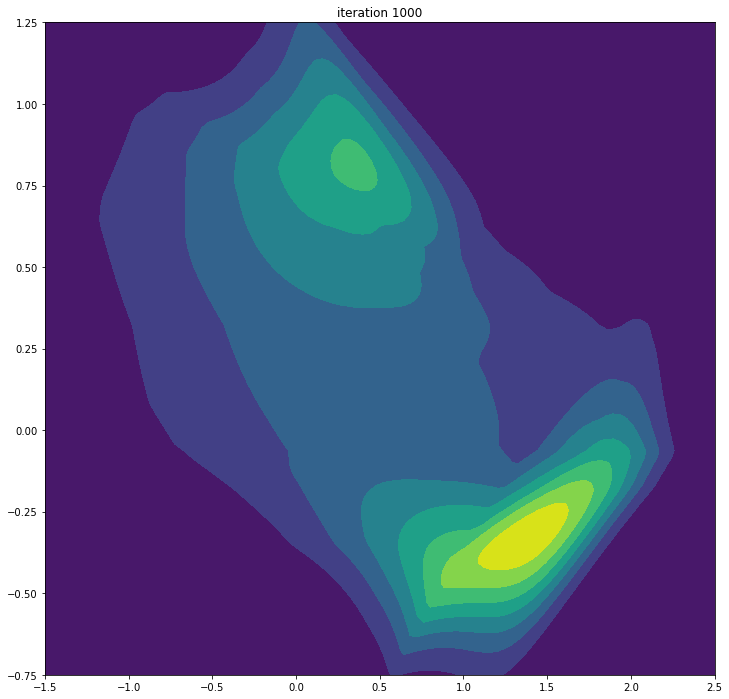

iteration: 1050, loss: tensor(1.5720, grad_fn=<NegBackward>)
iteration: 1100, loss: tensor(1.6075, grad_fn=<NegBackward>)
iteration: 1150, loss: tensor(1.5000, grad_fn=<NegBackward>)
iteration: 1200, loss: tensor(1.4856, grad_fn=<NegBackward>)
iteration: 1250, loss: tensor(1.4842, grad_fn=<NegBackward>)
iteration: 1300, loss: tensor(1.4982, grad_fn=<NegBackward>)
iteration: 1350, loss: tensor(1.4772, grad_fn=<NegBackward>)
iteration: 1400, loss: tensor(1.4156, grad_fn=<NegBackward>)
iteration: 1450, loss: tensor(1.4478, grad_fn=<NegBackward>)
iteration: 1500, loss: tensor(1.4576, grad_fn=<NegBackward>)


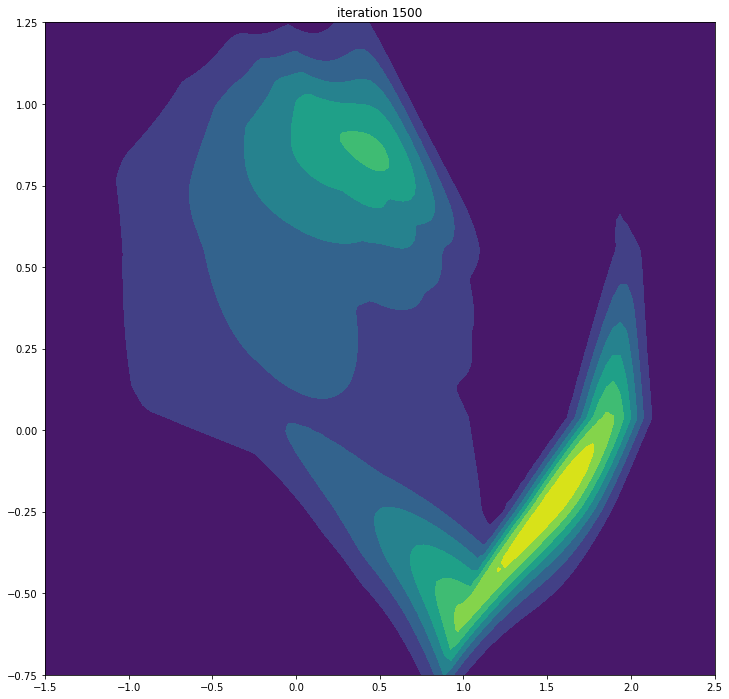

iteration: 1550, loss: tensor(1.3944, grad_fn=<NegBackward>)
iteration: 1600, loss: tensor(1.5015, grad_fn=<NegBackward>)
iteration: 1650, loss: tensor(1.4403, grad_fn=<NegBackward>)
iteration: 1700, loss: tensor(1.4602, grad_fn=<NegBackward>)
iteration: 1750, loss: tensor(1.4383, grad_fn=<NegBackward>)
iteration: 1800, loss: tensor(1.3984, grad_fn=<NegBackward>)
iteration: 1850, loss: tensor(1.4674, grad_fn=<NegBackward>)
iteration: 1900, loss: tensor(1.4581, grad_fn=<NegBackward>)
iteration: 1950, loss: tensor(1.4266, grad_fn=<NegBackward>)
iteration: 2000, loss: tensor(1.4303, grad_fn=<NegBackward>)


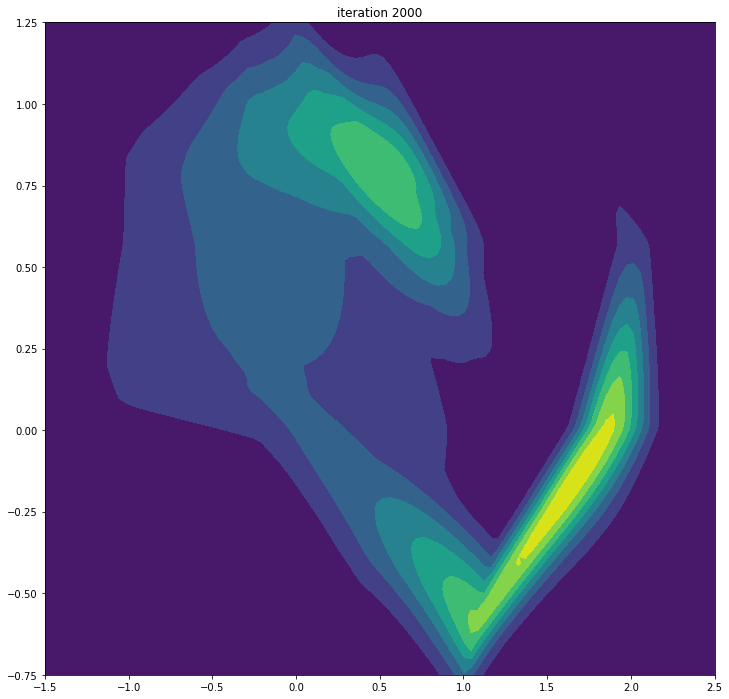

iteration: 2050, loss: tensor(1.4065, grad_fn=<NegBackward>)
iteration: 2100, loss: tensor(1.3644, grad_fn=<NegBackward>)
iteration: 2150, loss: tensor(1.4163, grad_fn=<NegBackward>)
iteration: 2200, loss: tensor(1.3892, grad_fn=<NegBackward>)
iteration: 2250, loss: tensor(1.3894, grad_fn=<NegBackward>)
iteration: 2300, loss: tensor(1.3900, grad_fn=<NegBackward>)
iteration: 2350, loss: tensor(1.3458, grad_fn=<NegBackward>)
iteration: 2400, loss: tensor(1.3500, grad_fn=<NegBackward>)
iteration: 2450, loss: tensor(1.3843, grad_fn=<NegBackward>)
iteration: 2500, loss: tensor(1.4302, grad_fn=<NegBackward>)


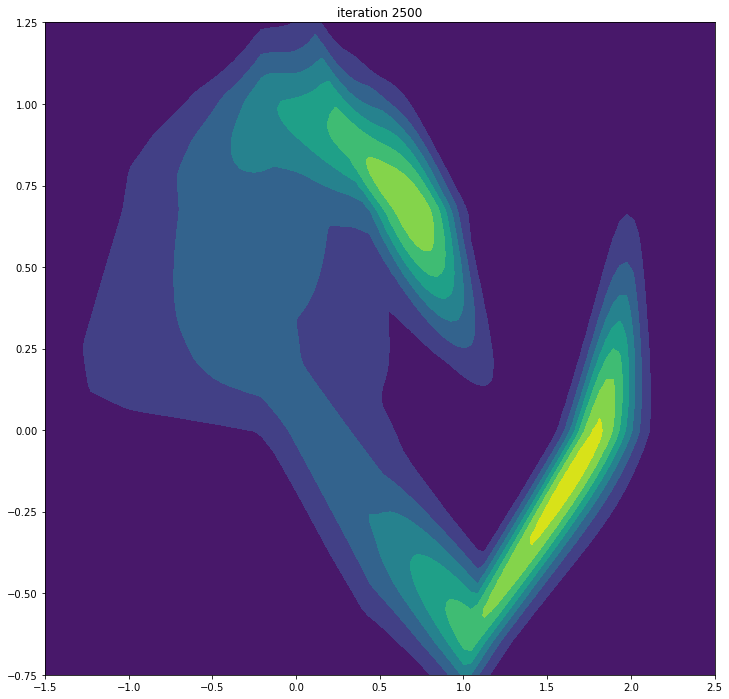

iteration: 2550, loss: tensor(1.3911, grad_fn=<NegBackward>)
iteration: 2600, loss: tensor(1.3213, grad_fn=<NegBackward>)
iteration: 2650, loss: tensor(1.3799, grad_fn=<NegBackward>)
iteration: 2700, loss: tensor(1.3795, grad_fn=<NegBackward>)
iteration: 2750, loss: tensor(1.3854, grad_fn=<NegBackward>)
iteration: 2800, loss: tensor(1.3656, grad_fn=<NegBackward>)
iteration: 2850, loss: tensor(1.3646, grad_fn=<NegBackward>)
iteration: 2900, loss: tensor(1.2618, grad_fn=<NegBackward>)
iteration: 2950, loss: tensor(1.3526, grad_fn=<NegBackward>)
iteration: 3000, loss: tensor(1.3390, grad_fn=<NegBackward>)


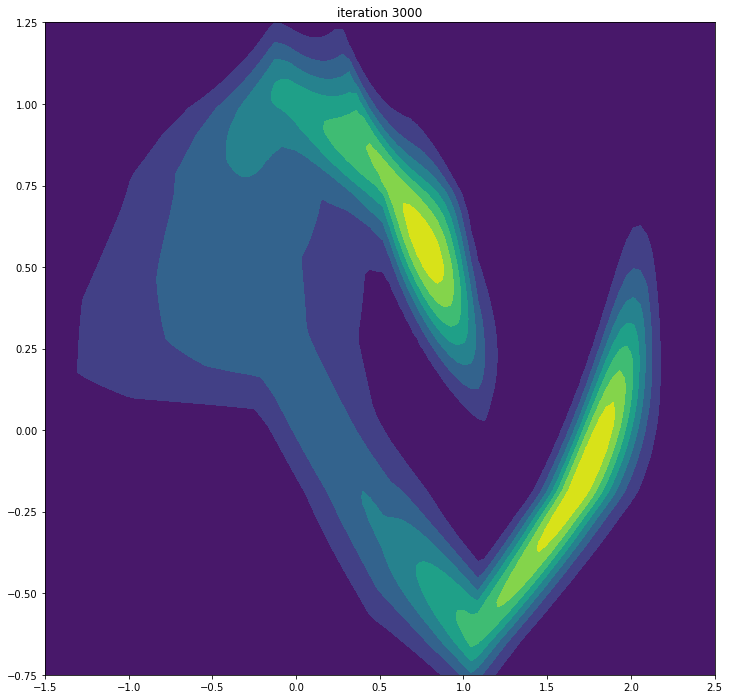

iteration: 3050, loss: tensor(1.4012, grad_fn=<NegBackward>)
iteration: 3100, loss: tensor(1.3898, grad_fn=<NegBackward>)
iteration: 3150, loss: tensor(1.2870, grad_fn=<NegBackward>)
iteration: 3200, loss: tensor(1.2900, grad_fn=<NegBackward>)
iteration: 3250, loss: tensor(1.3279, grad_fn=<NegBackward>)
iteration: 3300, loss: tensor(1.2576, grad_fn=<NegBackward>)
iteration: 3350, loss: tensor(1.3245, grad_fn=<NegBackward>)
iteration: 3400, loss: tensor(1.3718, grad_fn=<NegBackward>)
iteration: 3450, loss: tensor(1.3427, grad_fn=<NegBackward>)
iteration: 3500, loss: tensor(1.3816, grad_fn=<NegBackward>)


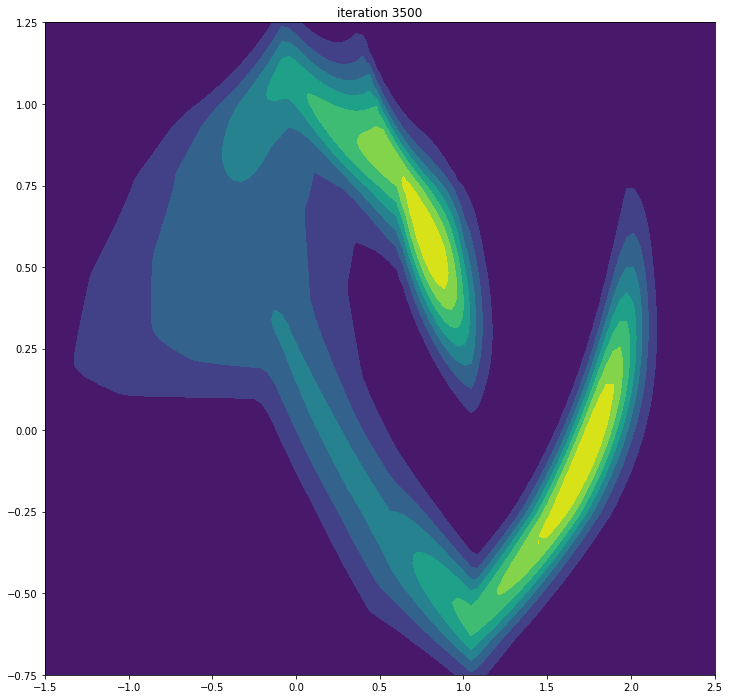

iteration: 3550, loss: tensor(1.2548, grad_fn=<NegBackward>)
iteration: 3600, loss: tensor(1.3002, grad_fn=<NegBackward>)
iteration: 3650, loss: tensor(1.2404, grad_fn=<NegBackward>)
iteration: 3700, loss: tensor(1.3439, grad_fn=<NegBackward>)
iteration: 3750, loss: tensor(1.2712, grad_fn=<NegBackward>)
iteration: 3800, loss: tensor(1.2339, grad_fn=<NegBackward>)
iteration: 3850, loss: tensor(1.3596, grad_fn=<NegBackward>)
iteration: 3900, loss: tensor(1.3087, grad_fn=<NegBackward>)
iteration: 3950, loss: tensor(1.2969, grad_fn=<NegBackward>)
iteration: 4000, loss: tensor(1.3123, grad_fn=<NegBackward>)


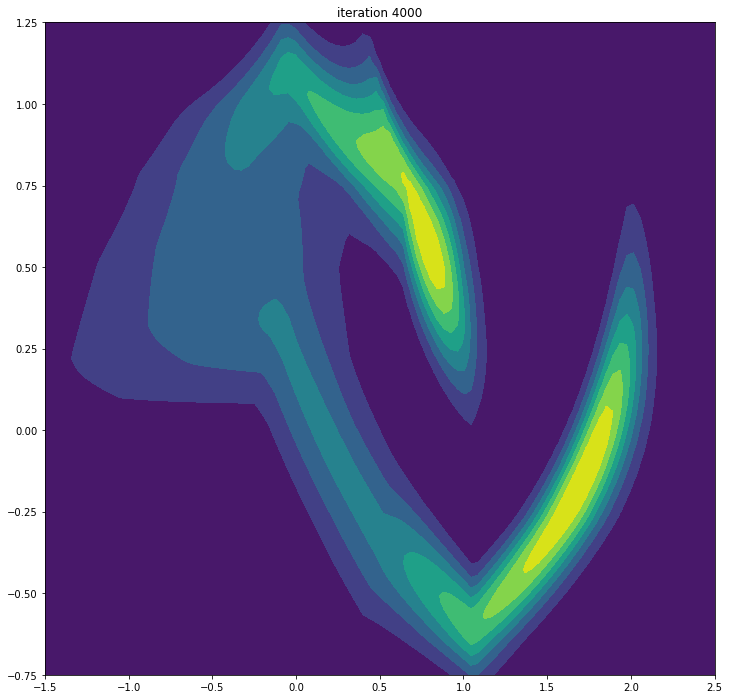

iteration: 4050, loss: tensor(1.3411, grad_fn=<NegBackward>)
iteration: 4100, loss: tensor(1.3336, grad_fn=<NegBackward>)
iteration: 4150, loss: tensor(1.2715, grad_fn=<NegBackward>)
iteration: 4200, loss: tensor(1.3476, grad_fn=<NegBackward>)
iteration: 4250, loss: tensor(1.2911, grad_fn=<NegBackward>)
iteration: 4300, loss: tensor(1.3611, grad_fn=<NegBackward>)
iteration: 4350, loss: tensor(1.2247, grad_fn=<NegBackward>)
iteration: 4400, loss: tensor(1.2651, grad_fn=<NegBackward>)
iteration: 4450, loss: tensor(1.2404, grad_fn=<NegBackward>)
iteration: 4500, loss: tensor(1.3073, grad_fn=<NegBackward>)


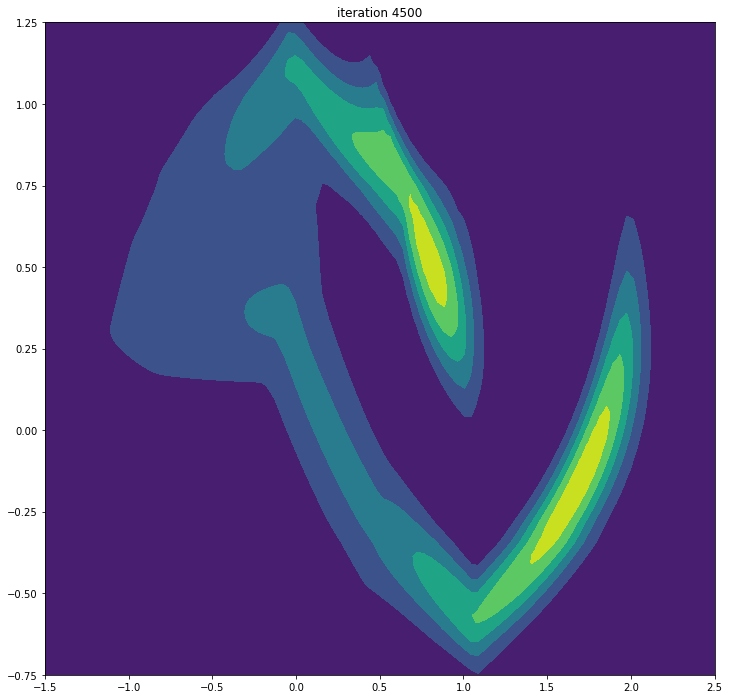

iteration: 4550, loss: tensor(1.3236, grad_fn=<NegBackward>)
iteration: 4600, loss: tensor(1.2938, grad_fn=<NegBackward>)
iteration: 4650, loss: tensor(1.2793, grad_fn=<NegBackward>)
iteration: 4700, loss: tensor(1.4287, grad_fn=<NegBackward>)
iteration: 4750, loss: tensor(1.2949, grad_fn=<NegBackward>)
iteration: 4800, loss: tensor(1.2512, grad_fn=<NegBackward>)
iteration: 4850, loss: tensor(1.3596, grad_fn=<NegBackward>)
iteration: 4900, loss: tensor(1.2469, grad_fn=<NegBackward>)
iteration: 4950, loss: tensor(1.2650, grad_fn=<NegBackward>)
iteration: 5000, loss: tensor(1.2679, grad_fn=<NegBackward>)


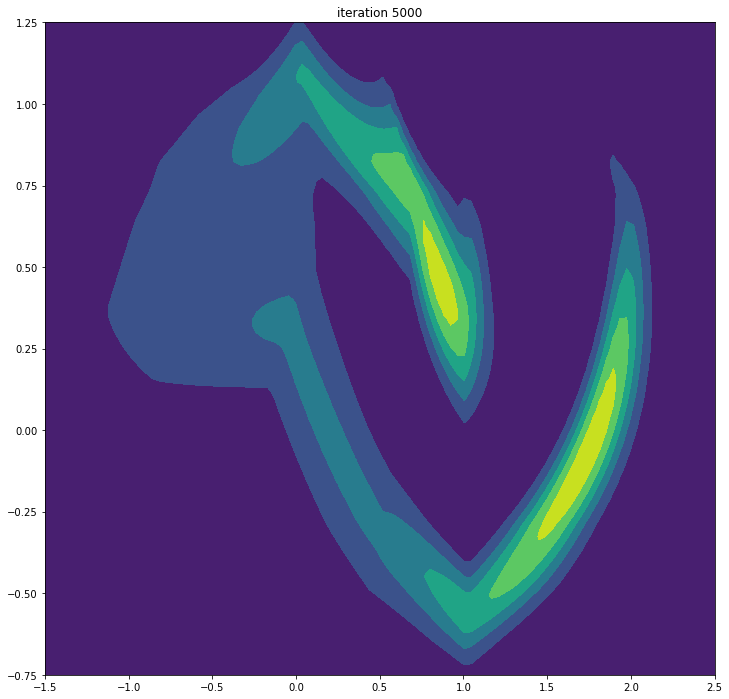

In [434]:
num_iter = 5000
for i in range(num_iter):
    x, y = datasets.make_moons(256, noise=.1)
    x = torch.tensor(x, dtype=torch.float32)
    optimizer.zero_grad()
    loss = -flow.log_prob(inputs=x).mean()
    if (i + 1) % 50 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-1.5, 2.5)
        yline = torch.linspace(-.75, 1.25)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

## Variational Inference with KSD

The following flows construct maps from a standard normal distribution to a target distribution. 

### Banana distribution target

#### Cubic splines

The following uses cubic spline flows from (https://arxiv.org/pdf/1906.02145.pdf). 

In [397]:
from nflows.transforms.autoregressive import MaskedPiecewiseCubicAutoregressiveTransform
from nflows.transforms.nonlinearities import Sigmoid
from nflows.transforms.nonlinearities import Logit

num_layers = 2
base_dist = StandardNormal(shape=[2]) 

transforms = []
for _ in range(num_layers):
    transforms.append(Sigmoid())
    transforms.append(MaskedPiecewiseCubicAutoregressiveTransform(num_bins = 10,features=2, 
                                                          hidden_features=4))
    transforms.append(Logit())
    
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist) #This base distribution is not needed for variation inference
optimizer = optim.Adam(flow.parameters())

In [398]:
a = 1
v1 = 1.5
v2 = 1.5

banana_test = lambda x: score_banana(x,a,v1,v2)

iteration: 100, loss: tensor(0.5075, grad_fn=<MeanBackward0>)
iteration: 200, loss: tensor(0.4292, grad_fn=<MeanBackward0>)
iteration: 300, loss: tensor(0.4200, grad_fn=<MeanBackward0>)
iteration: 400, loss: tensor(0.3769, grad_fn=<MeanBackward0>)
iteration: 500, loss: tensor(0.3385, grad_fn=<MeanBackward0>)


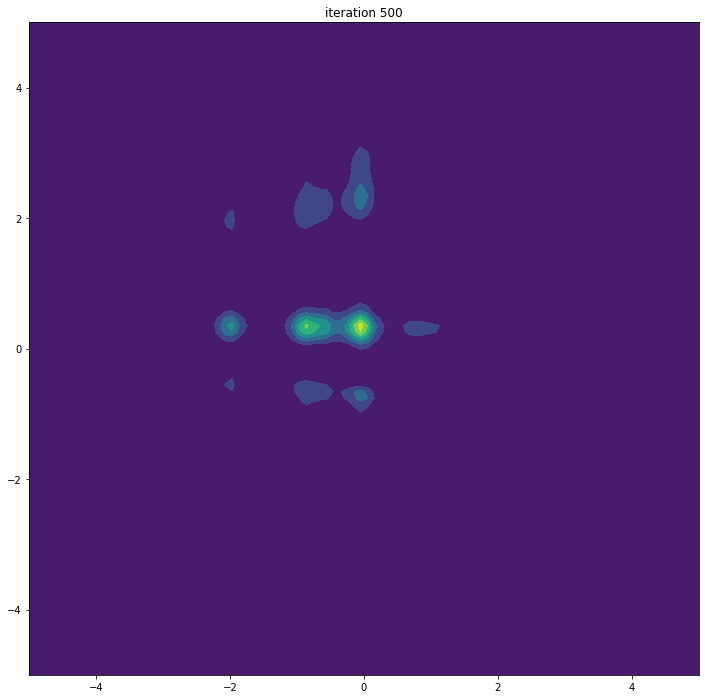

iteration: 600, loss: tensor(0.3475, grad_fn=<MeanBackward0>)
iteration: 700, loss: tensor(0.3003, grad_fn=<MeanBackward0>)
iteration: 800, loss: tensor(0.2809, grad_fn=<MeanBackward0>)
iteration: 900, loss: tensor(0.2485, grad_fn=<MeanBackward0>)
iteration: 1000, loss: tensor(0.2964, grad_fn=<MeanBackward0>)


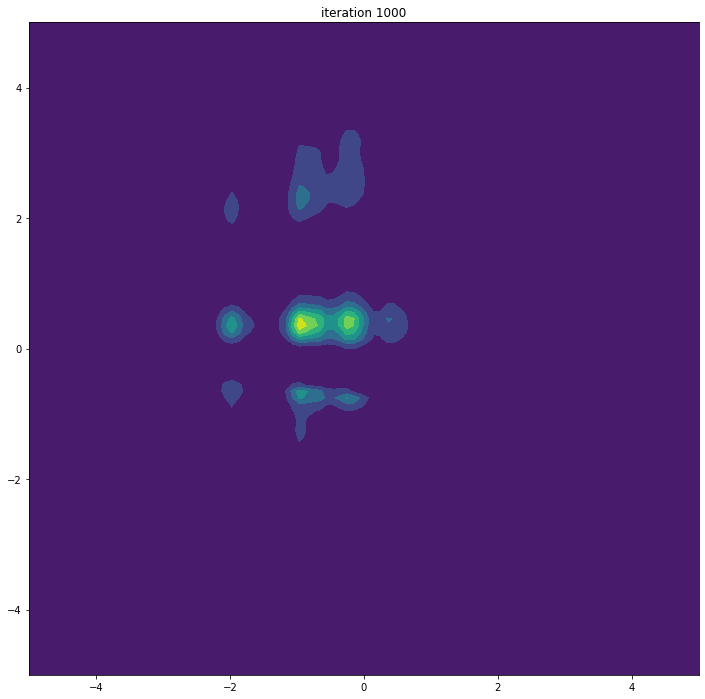

iteration: 1100, loss: tensor(0.3606, grad_fn=<MeanBackward0>)
iteration: 1200, loss: tensor(0.2792, grad_fn=<MeanBackward0>)
iteration: 1300, loss: tensor(0.2385, grad_fn=<MeanBackward0>)
iteration: 1400, loss: tensor(0.2787, grad_fn=<MeanBackward0>)
iteration: 1500, loss: tensor(0.2260, grad_fn=<MeanBackward0>)


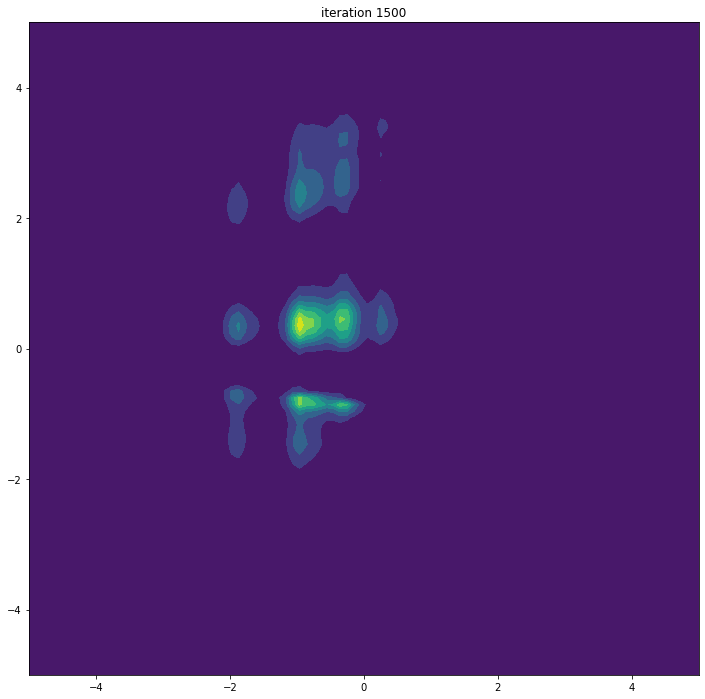

iteration: 1600, loss: tensor(0.2449, grad_fn=<MeanBackward0>)
iteration: 1700, loss: tensor(0.2486, grad_fn=<MeanBackward0>)
iteration: 1800, loss: tensor(0.2068, grad_fn=<MeanBackward0>)
iteration: 1900, loss: tensor(0.2349, grad_fn=<MeanBackward0>)
iteration: 2000, loss: tensor(0.2519, grad_fn=<MeanBackward0>)


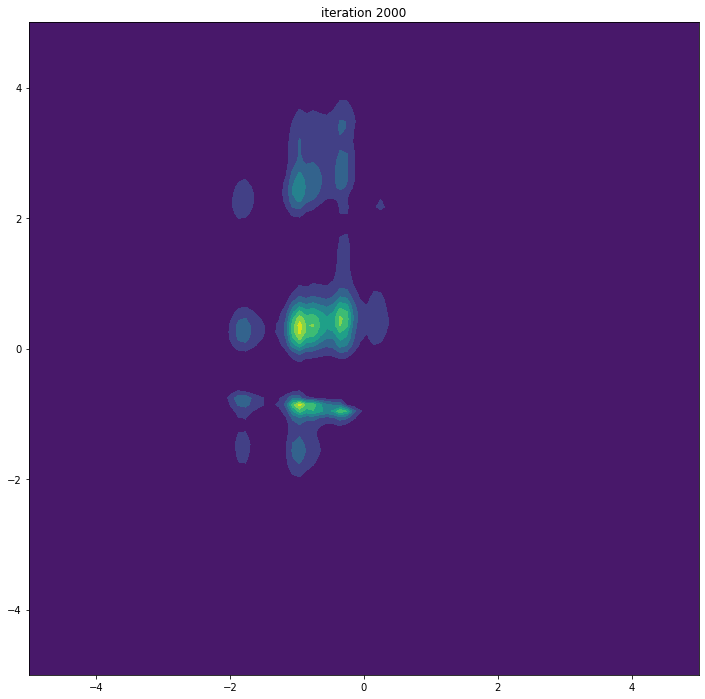

iteration: 2100, loss: tensor(0.2678, grad_fn=<MeanBackward0>)
iteration: 2200, loss: tensor(0.2114, grad_fn=<MeanBackward0>)
iteration: 2300, loss: tensor(0.3547, grad_fn=<MeanBackward0>)
iteration: 2400, loss: tensor(0.2181, grad_fn=<MeanBackward0>)
iteration: 2500, loss: tensor(0.2244, grad_fn=<MeanBackward0>)


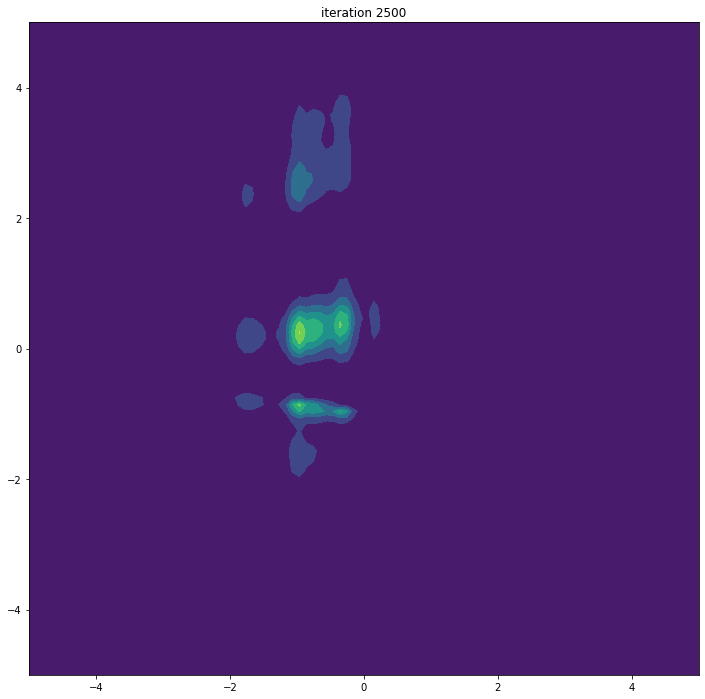

iteration: 2600, loss: tensor(0.2365, grad_fn=<MeanBackward0>)
iteration: 2700, loss: tensor(0.2370, grad_fn=<MeanBackward0>)
iteration: 2800, loss: tensor(0.2069, grad_fn=<MeanBackward0>)
iteration: 2900, loss: tensor(0.2004, grad_fn=<MeanBackward0>)
iteration: 3000, loss: tensor(0.1952, grad_fn=<MeanBackward0>)


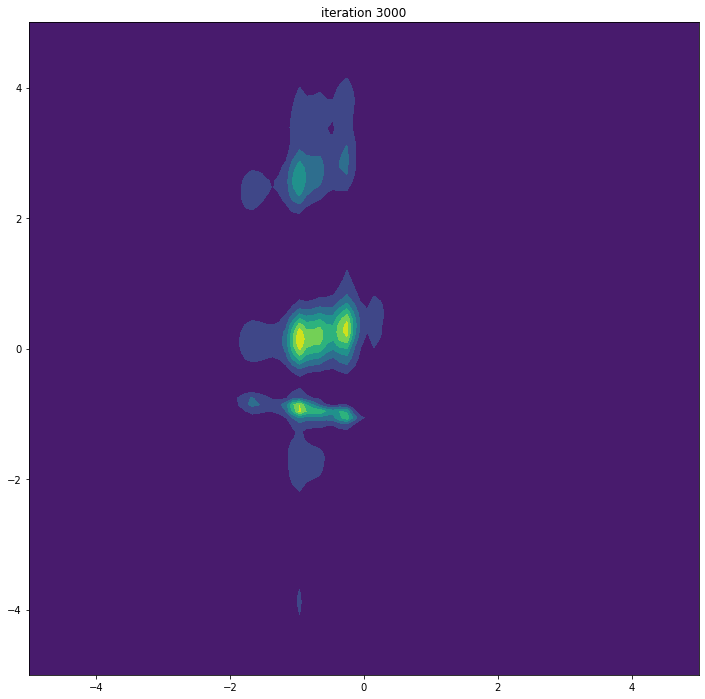

iteration: 3100, loss: tensor(0.1886, grad_fn=<MeanBackward0>)
iteration: 3200, loss: tensor(0.2252, grad_fn=<MeanBackward0>)
iteration: 3300, loss: tensor(0.2017, grad_fn=<MeanBackward0>)
iteration: 3400, loss: tensor(0.1978, grad_fn=<MeanBackward0>)
iteration: 3500, loss: tensor(0.2049, grad_fn=<MeanBackward0>)


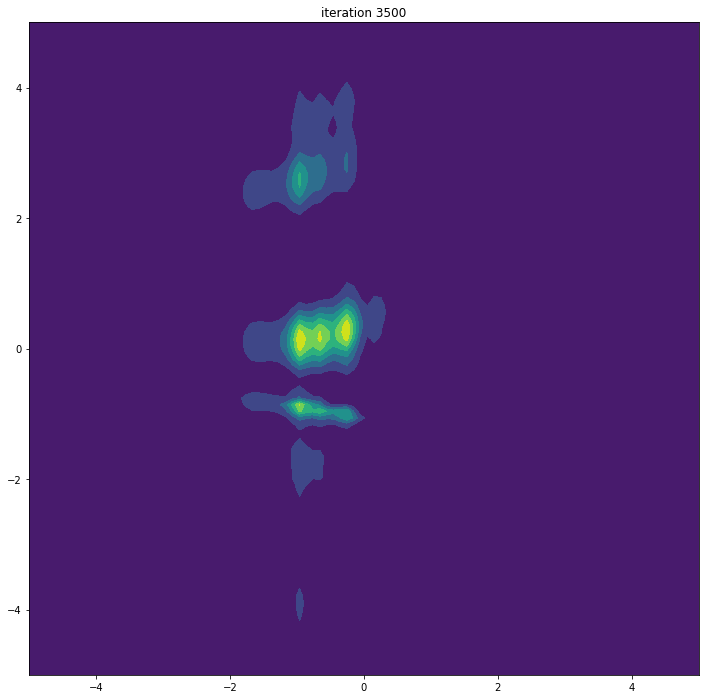

iteration: 3600, loss: tensor(0.2592, grad_fn=<MeanBackward0>)
iteration: 3700, loss: tensor(0.1928, grad_fn=<MeanBackward0>)
iteration: 3800, loss: tensor(0.1898, grad_fn=<MeanBackward0>)
iteration: 3900, loss: tensor(0.2069, grad_fn=<MeanBackward0>)
iteration: 4000, loss: tensor(0.2054, grad_fn=<MeanBackward0>)


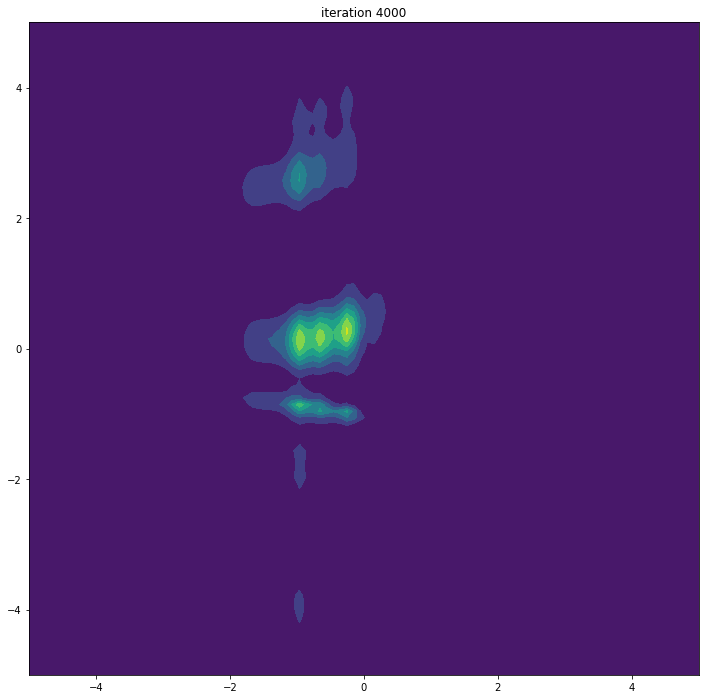

iteration: 4100, loss: tensor(0.1992, grad_fn=<MeanBackward0>)
iteration: 4200, loss: tensor(0.1879, grad_fn=<MeanBackward0>)
iteration: 4300, loss: tensor(0.2067, grad_fn=<MeanBackward0>)
iteration: 4400, loss: tensor(0.1802, grad_fn=<MeanBackward0>)
iteration: 4500, loss: tensor(0.2153, grad_fn=<MeanBackward0>)


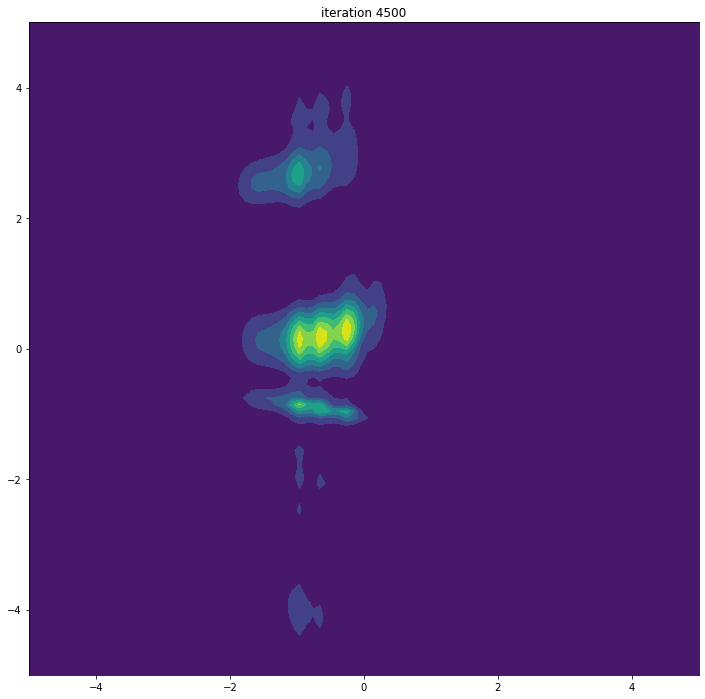

iteration: 4600, loss: tensor(0.2057, grad_fn=<MeanBackward0>)
iteration: 4700, loss: tensor(0.1992, grad_fn=<MeanBackward0>)
iteration: 4800, loss: tensor(0.1860, grad_fn=<MeanBackward0>)
iteration: 4900, loss: tensor(0.1905, grad_fn=<MeanBackward0>)
iteration: 5000, loss: tensor(0.2231, grad_fn=<MeanBackward0>)


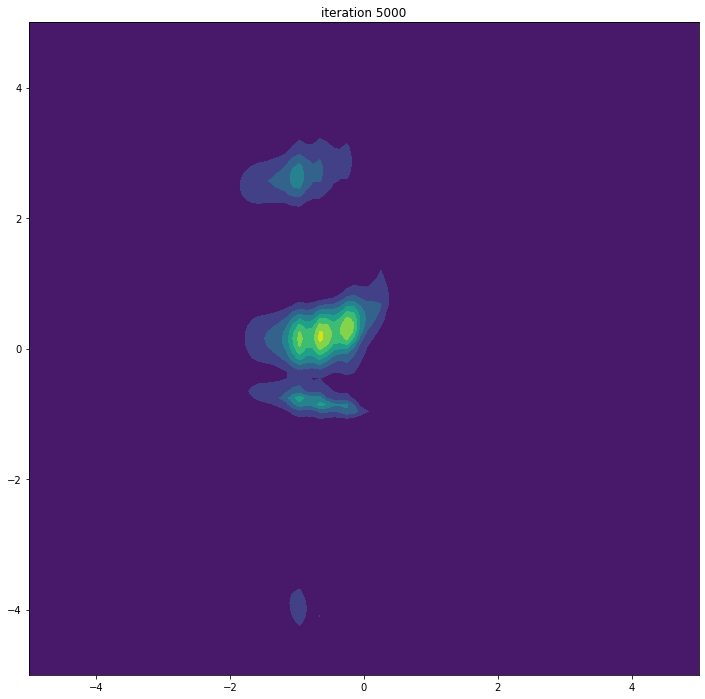

iteration: 5100, loss: tensor(0.1818, grad_fn=<MeanBackward0>)
iteration: 5200, loss: tensor(0.2131, grad_fn=<MeanBackward0>)
iteration: 5300, loss: tensor(0.1744, grad_fn=<MeanBackward0>)
iteration: 5400, loss: tensor(0.1941, grad_fn=<MeanBackward0>)
iteration: 5500, loss: tensor(0.2080, grad_fn=<MeanBackward0>)


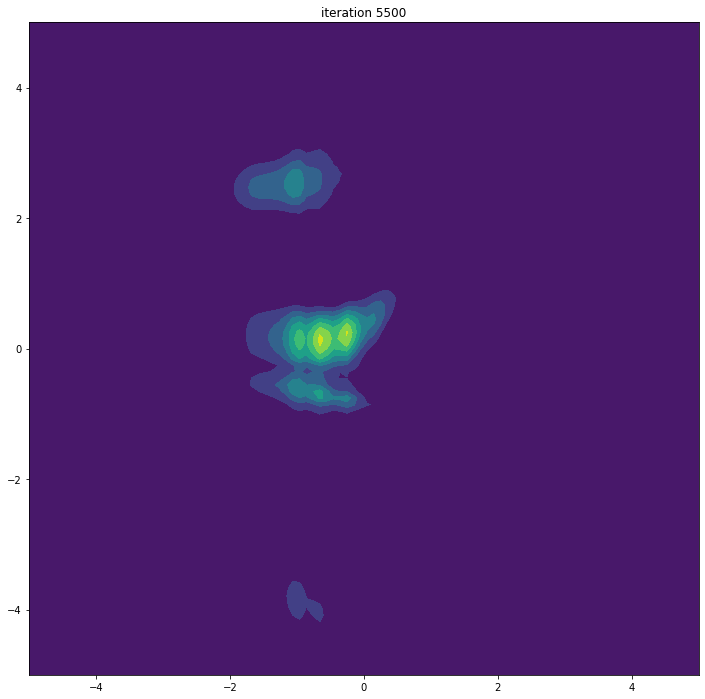

iteration: 5600, loss: tensor(0.1985, grad_fn=<MeanBackward0>)
iteration: 5700, loss: tensor(0.1671, grad_fn=<MeanBackward0>)
iteration: 5800, loss: tensor(0.1655, grad_fn=<MeanBackward0>)
iteration: 5900, loss: tensor(0.1918, grad_fn=<MeanBackward0>)
iteration: 6000, loss: tensor(0.1881, grad_fn=<MeanBackward0>)


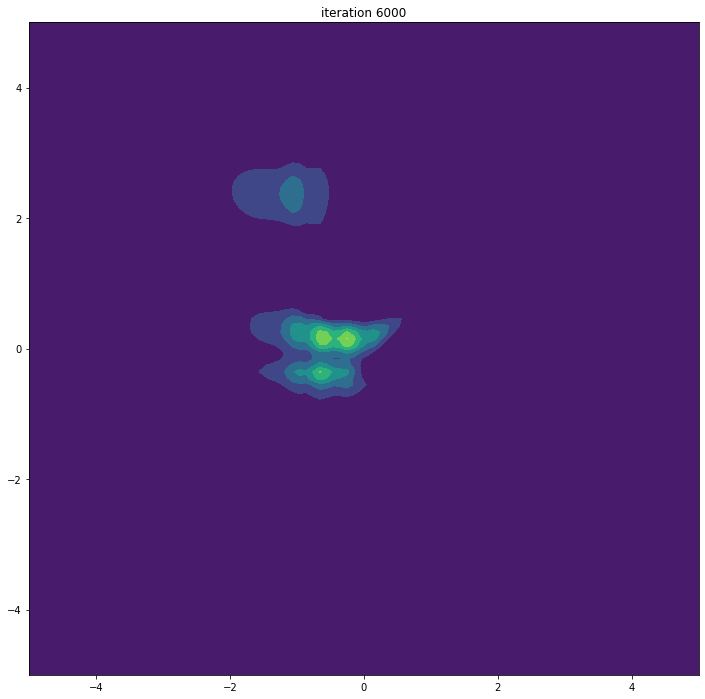

iteration: 6100, loss: tensor(0.1669, grad_fn=<MeanBackward0>)
iteration: 6200, loss: tensor(0.1865, grad_fn=<MeanBackward0>)
iteration: 6300, loss: tensor(0.1575, grad_fn=<MeanBackward0>)
iteration: 6400, loss: tensor(0.1560, grad_fn=<MeanBackward0>)
iteration: 6500, loss: tensor(0.1707, grad_fn=<MeanBackward0>)


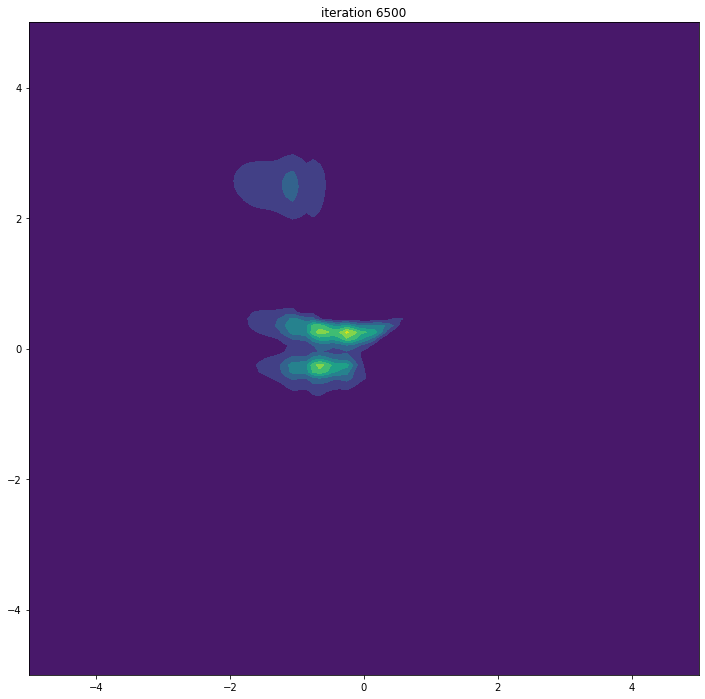

iteration: 6600, loss: tensor(0.1687, grad_fn=<MeanBackward0>)
iteration: 6700, loss: tensor(0.1383, grad_fn=<MeanBackward0>)
iteration: 6800, loss: tensor(0.1840, grad_fn=<MeanBackward0>)
iteration: 6900, loss: tensor(0.1438, grad_fn=<MeanBackward0>)
iteration: 7000, loss: tensor(0.1509, grad_fn=<MeanBackward0>)


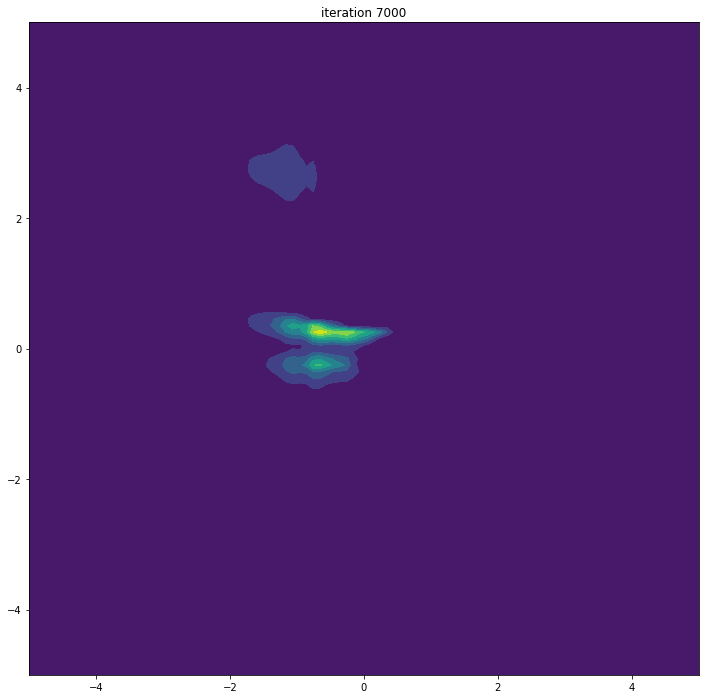

iteration: 7100, loss: tensor(0.1560, grad_fn=<MeanBackward0>)
iteration: 7200, loss: tensor(0.1438, grad_fn=<MeanBackward0>)
iteration: 7300, loss: tensor(0.1329, grad_fn=<MeanBackward0>)
iteration: 7400, loss: tensor(0.1556, grad_fn=<MeanBackward0>)
iteration: 7500, loss: tensor(0.1791, grad_fn=<MeanBackward0>)


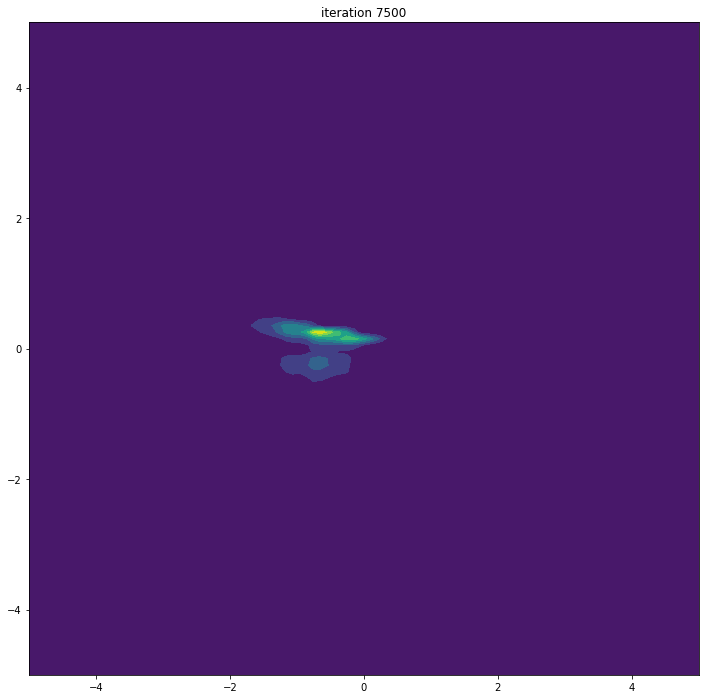

iteration: 7600, loss: tensor(0.1501, grad_fn=<MeanBackward0>)
iteration: 7700, loss: tensor(0.1587, grad_fn=<MeanBackward0>)
iteration: 7800, loss: tensor(0.1477, grad_fn=<MeanBackward0>)
iteration: 7900, loss: tensor(0.1456, grad_fn=<MeanBackward0>)
iteration: 8000, loss: tensor(0.1628, grad_fn=<MeanBackward0>)


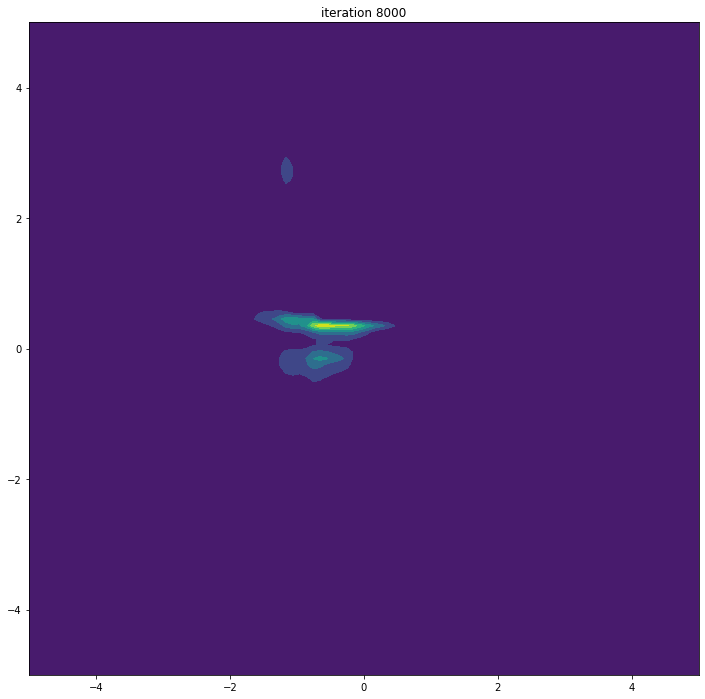

iteration: 8100, loss: tensor(0.1405, grad_fn=<MeanBackward0>)
iteration: 8200, loss: tensor(0.1441, grad_fn=<MeanBackward0>)
iteration: 8300, loss: tensor(0.1448, grad_fn=<MeanBackward0>)
iteration: 8400, loss: tensor(0.1518, grad_fn=<MeanBackward0>)
iteration: 8500, loss: tensor(0.1571, grad_fn=<MeanBackward0>)


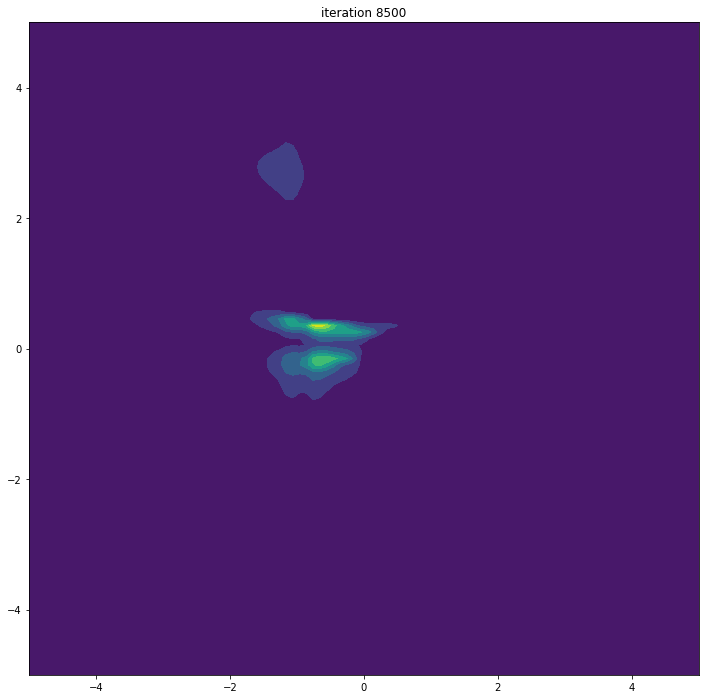

iteration: 8600, loss: tensor(0.1332, grad_fn=<MeanBackward0>)
iteration: 8700, loss: tensor(0.1408, grad_fn=<MeanBackward0>)
iteration: 8800, loss: tensor(0.1653, grad_fn=<MeanBackward0>)
iteration: 8900, loss: tensor(0.1398, grad_fn=<MeanBackward0>)
iteration: 9000, loss: tensor(0.1469, grad_fn=<MeanBackward0>)


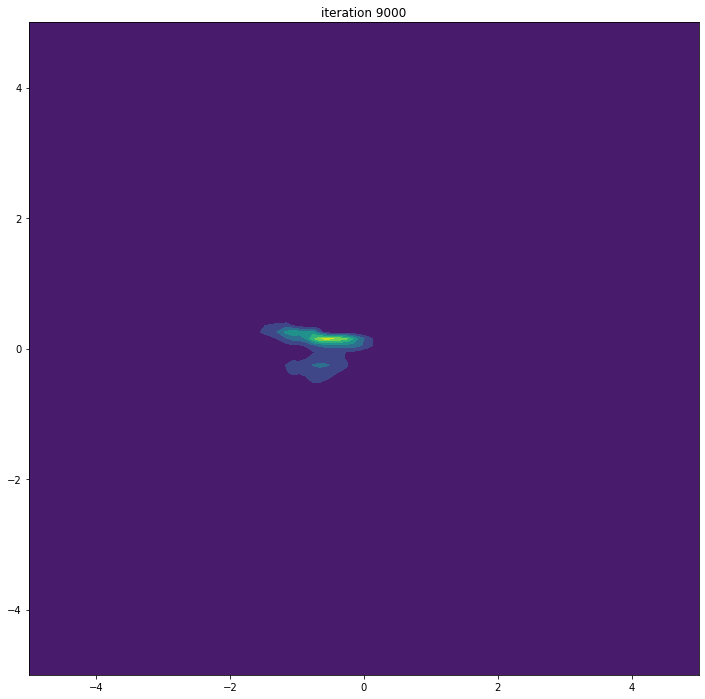

iteration: 9100, loss: tensor(0.1499, grad_fn=<MeanBackward0>)
iteration: 9200, loss: tensor(0.1674, grad_fn=<MeanBackward0>)
iteration: 9300, loss: tensor(0.1503, grad_fn=<MeanBackward0>)
iteration: 9400, loss: tensor(0.1598, grad_fn=<MeanBackward0>)
iteration: 9500, loss: tensor(0.1326, grad_fn=<MeanBackward0>)


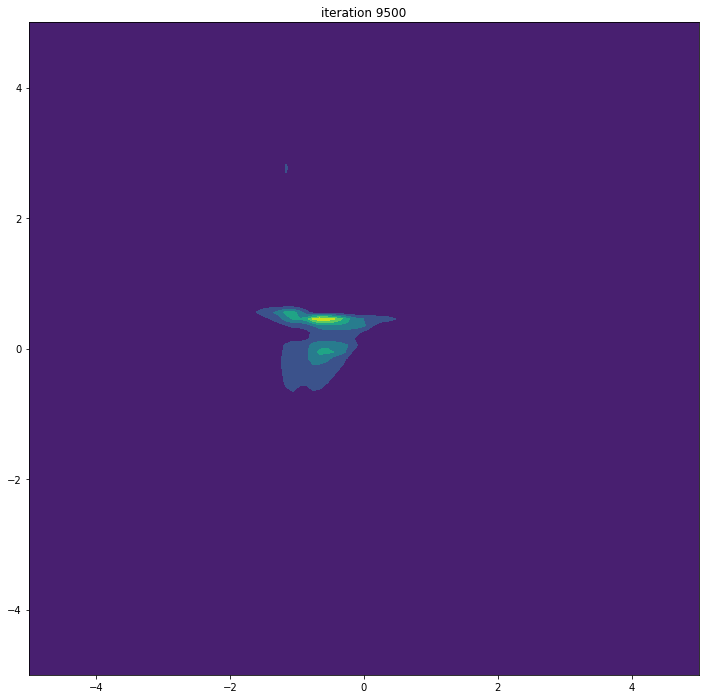

iteration: 9600, loss: tensor(0.1524, grad_fn=<MeanBackward0>)
iteration: 9700, loss: tensor(0.1439, grad_fn=<MeanBackward0>)
iteration: 9800, loss: tensor(0.1531, grad_fn=<MeanBackward0>)
iteration: 9900, loss: tensor(0.1677, grad_fn=<MeanBackward0>)
iteration: 10000, loss: tensor(0.1519, grad_fn=<MeanBackward0>)


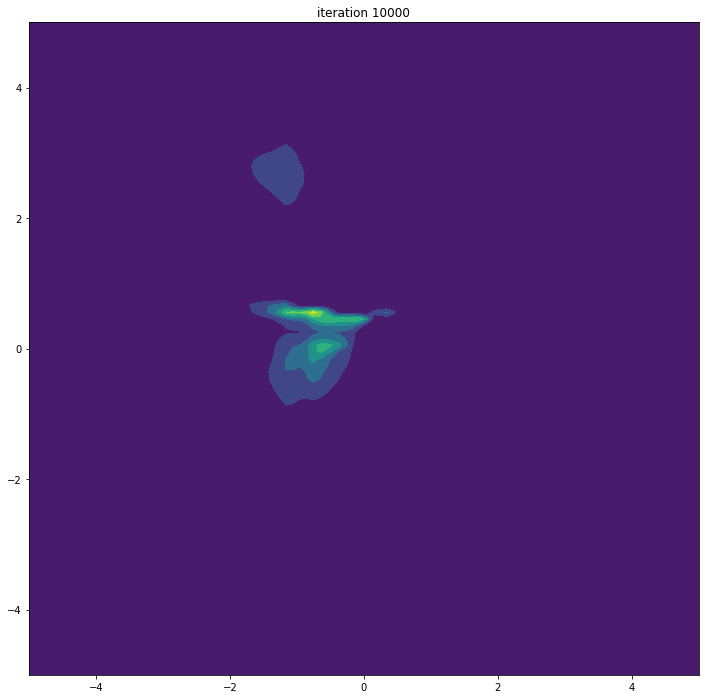

In [399]:
num_iter = 10000
for i in range(num_iter):
    N = 100 # 100 samples from base distribution
    x = base_dist.sample(N)

    optimizer.zero_grad()
    t_x = flow._transform(x)[0]

    loss = loss_KSD(t_x,banana_test)
    if (i + 1) % 100 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-5,5)
        yline = torch.linspace(-5,5)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

The following plot is of the target density and our samples.

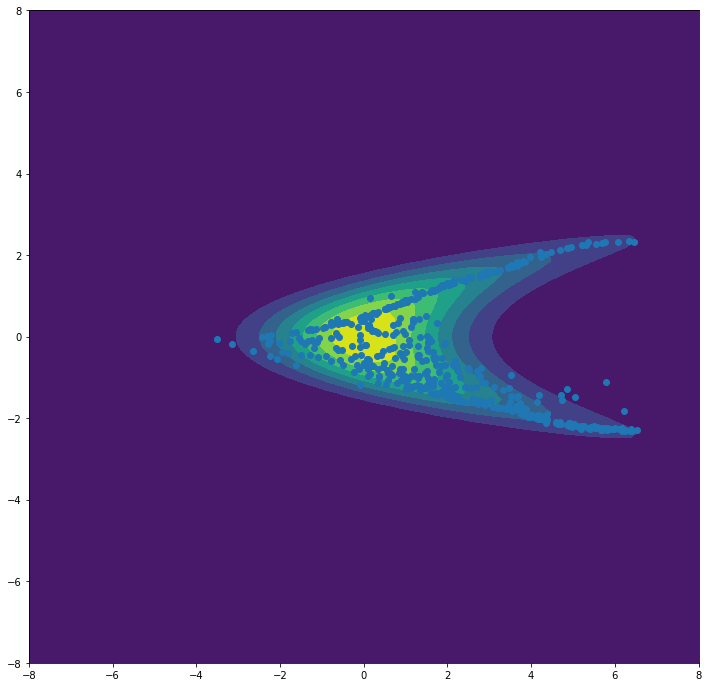

In [402]:
plot_banana(a,v1,v2)

test = base_dist.sample(500)
t_test = flow._transform(test)[0]
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1])

plt.show()

#### Masked Autoregressive Flow

The following is a Masked Autoregressive Flow for Density Estimation from (https://arxiv.org/pdf/1705.07057.pdf).

In [412]:
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.permutations import ReversePermutation

num_layers = 2
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

iteration: 100, loss: tensor(0.7717, grad_fn=<MeanBackward0>)
iteration: 200, loss: tensor(0.4674, grad_fn=<MeanBackward0>)
iteration: 300, loss: tensor(0.3453, grad_fn=<MeanBackward0>)
iteration: 400, loss: tensor(0.3590, grad_fn=<MeanBackward0>)
iteration: 500, loss: tensor(0.3871, grad_fn=<MeanBackward0>)


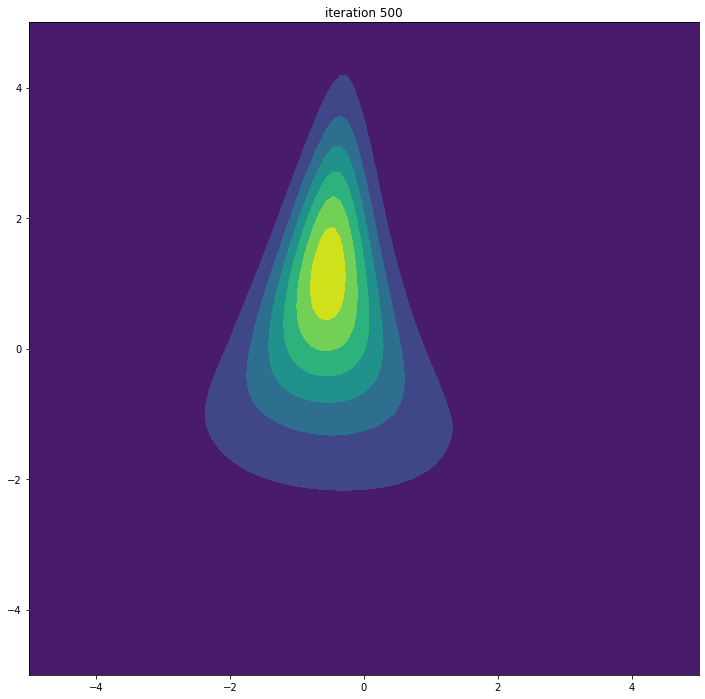

iteration: 600, loss: tensor(0.3730, grad_fn=<MeanBackward0>)
iteration: 700, loss: tensor(0.3084, grad_fn=<MeanBackward0>)
iteration: 800, loss: tensor(0.3175, grad_fn=<MeanBackward0>)
iteration: 900, loss: tensor(0.3456, grad_fn=<MeanBackward0>)
iteration: 1000, loss: tensor(0.3162, grad_fn=<MeanBackward0>)


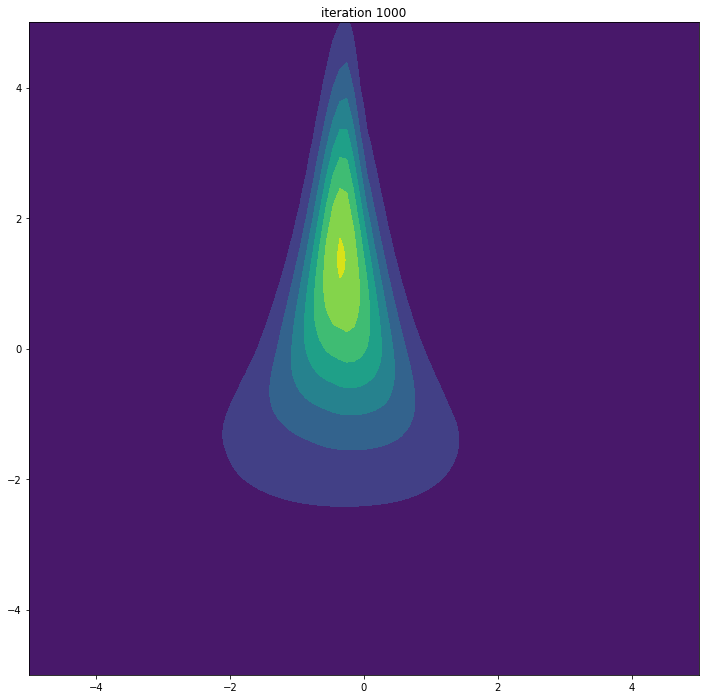

iteration: 1100, loss: tensor(0.3089, grad_fn=<MeanBackward0>)
iteration: 1200, loss: tensor(0.3702, grad_fn=<MeanBackward0>)
iteration: 1300, loss: tensor(0.3374, grad_fn=<MeanBackward0>)
iteration: 1400, loss: tensor(0.3444, grad_fn=<MeanBackward0>)
iteration: 1500, loss: tensor(0.3557, grad_fn=<MeanBackward0>)


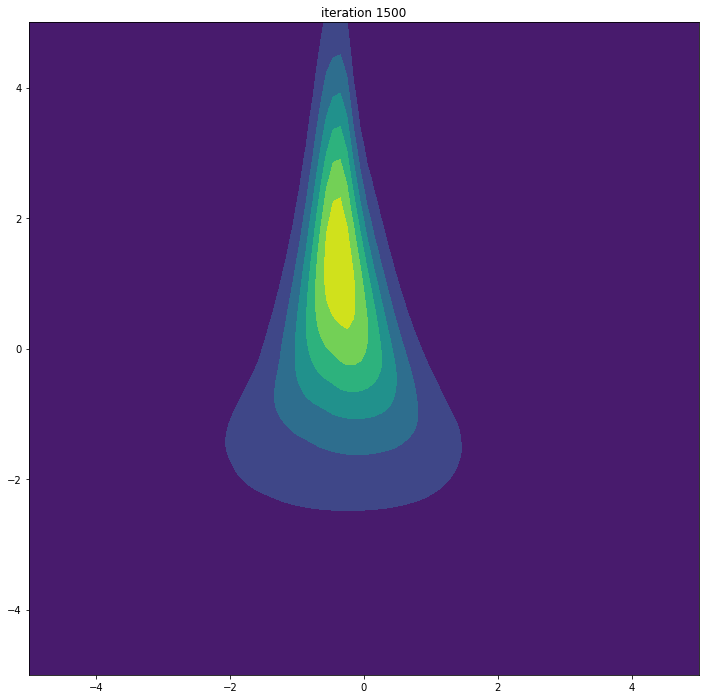

iteration: 1600, loss: tensor(0.3307, grad_fn=<MeanBackward0>)
iteration: 1700, loss: tensor(0.3033, grad_fn=<MeanBackward0>)
iteration: 1800, loss: tensor(0.2838, grad_fn=<MeanBackward0>)
iteration: 1900, loss: tensor(0.3287, grad_fn=<MeanBackward0>)
iteration: 2000, loss: tensor(0.2919, grad_fn=<MeanBackward0>)


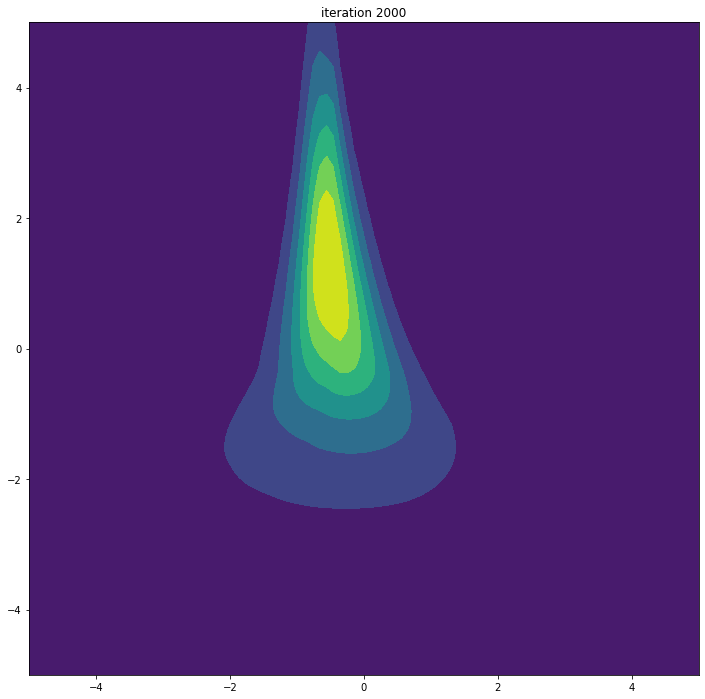

iteration: 2100, loss: tensor(0.3045, grad_fn=<MeanBackward0>)
iteration: 2200, loss: tensor(0.2942, grad_fn=<MeanBackward0>)
iteration: 2300, loss: tensor(0.2701, grad_fn=<MeanBackward0>)
iteration: 2400, loss: tensor(0.3046, grad_fn=<MeanBackward0>)
iteration: 2500, loss: tensor(0.3275, grad_fn=<MeanBackward0>)


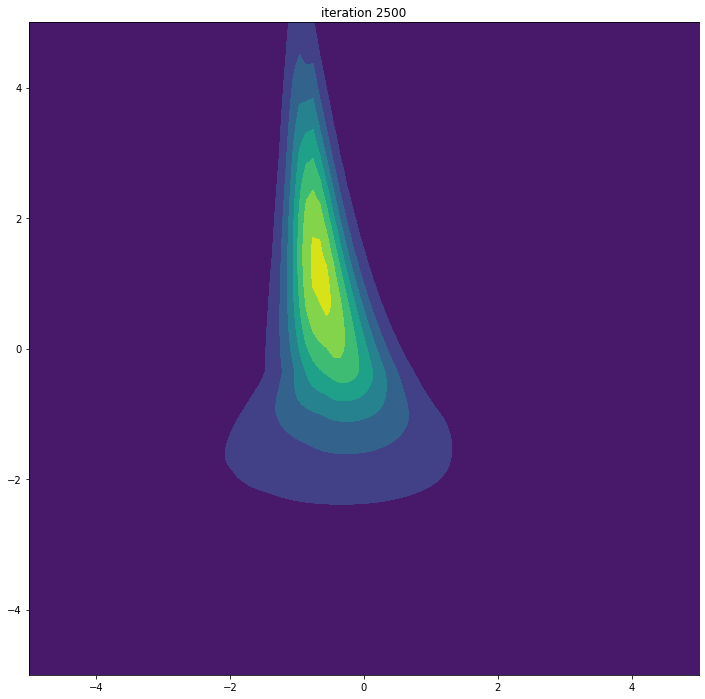

iteration: 2600, loss: tensor(0.2562, grad_fn=<MeanBackward0>)
iteration: 2700, loss: tensor(0.3215, grad_fn=<MeanBackward0>)
iteration: 2800, loss: tensor(0.2701, grad_fn=<MeanBackward0>)
iteration: 2900, loss: tensor(0.2671, grad_fn=<MeanBackward0>)
iteration: 3000, loss: tensor(0.3074, grad_fn=<MeanBackward0>)


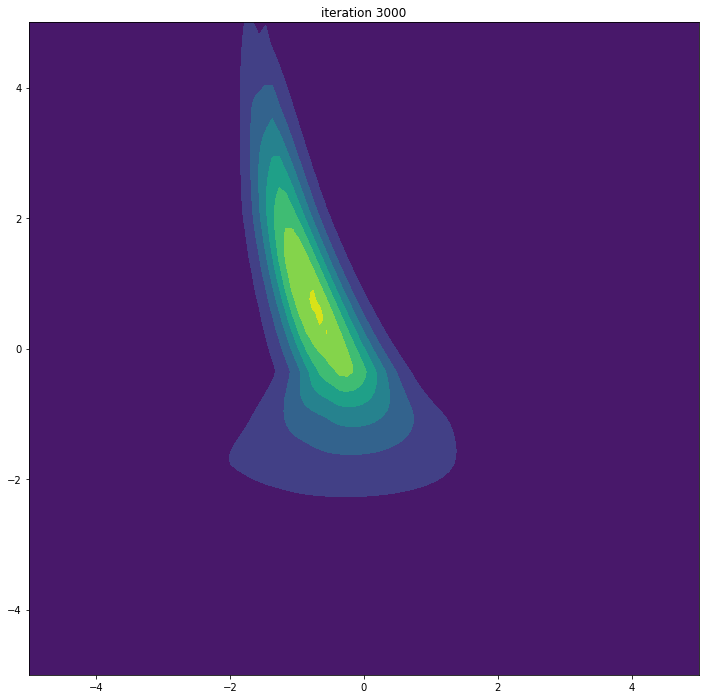

iteration: 3100, loss: tensor(0.2666, grad_fn=<MeanBackward0>)
iteration: 3200, loss: tensor(0.2611, grad_fn=<MeanBackward0>)
iteration: 3300, loss: tensor(0.2589, grad_fn=<MeanBackward0>)
iteration: 3400, loss: tensor(0.2523, grad_fn=<MeanBackward0>)
iteration: 3500, loss: tensor(0.2433, grad_fn=<MeanBackward0>)


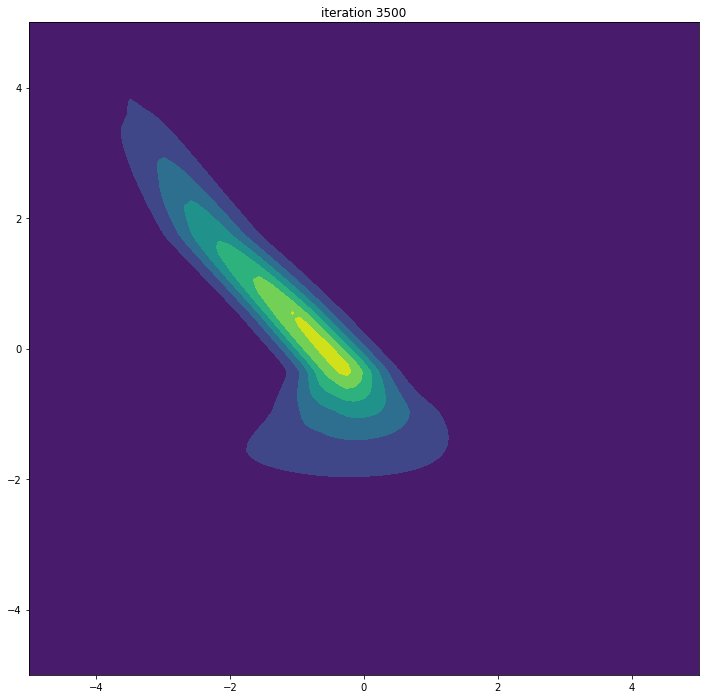

iteration: 3600, loss: tensor(0.2414, grad_fn=<MeanBackward0>)
iteration: 3700, loss: tensor(0.2101, grad_fn=<MeanBackward0>)
iteration: 3800, loss: tensor(0.2289, grad_fn=<MeanBackward0>)
iteration: 3900, loss: tensor(0.1894, grad_fn=<MeanBackward0>)
iteration: 4000, loss: tensor(0.2019, grad_fn=<MeanBackward0>)


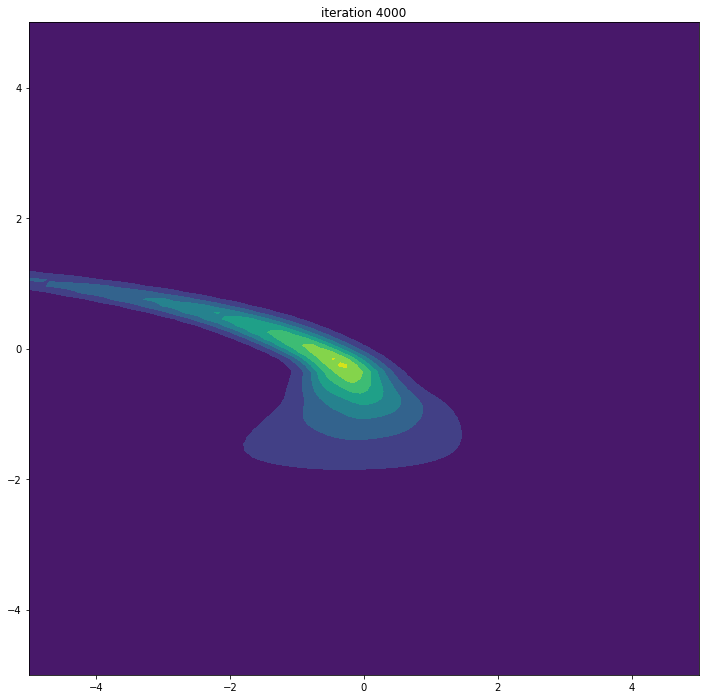

iteration: 4100, loss: tensor(0.2106, grad_fn=<MeanBackward0>)
iteration: 4200, loss: tensor(0.1971, grad_fn=<MeanBackward0>)
iteration: 4300, loss: tensor(0.1922, grad_fn=<MeanBackward0>)
iteration: 4400, loss: tensor(0.1874, grad_fn=<MeanBackward0>)
iteration: 4500, loss: tensor(0.1848, grad_fn=<MeanBackward0>)


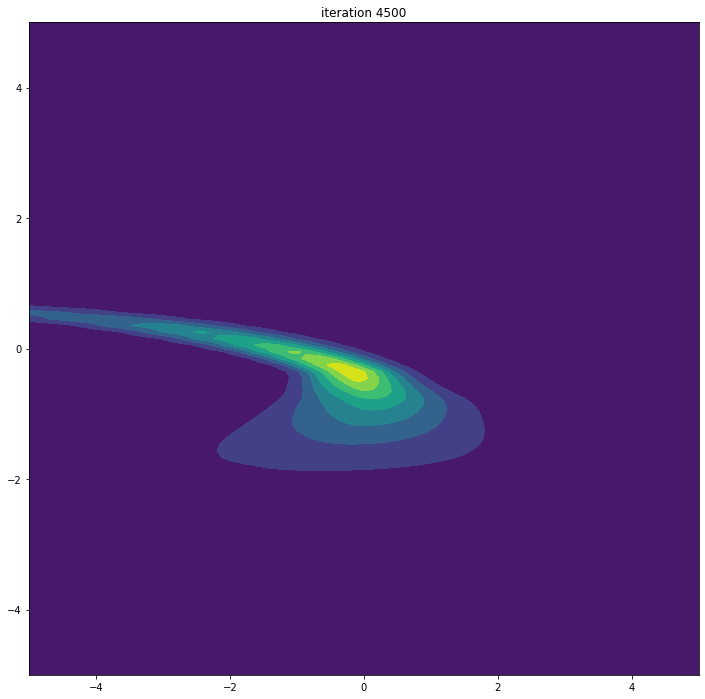

iteration: 4600, loss: tensor(0.2029, grad_fn=<MeanBackward0>)
iteration: 4700, loss: tensor(0.1779, grad_fn=<MeanBackward0>)
iteration: 4800, loss: tensor(0.1619, grad_fn=<MeanBackward0>)
iteration: 4900, loss: tensor(0.1624, grad_fn=<MeanBackward0>)
iteration: 5000, loss: tensor(0.1693, grad_fn=<MeanBackward0>)


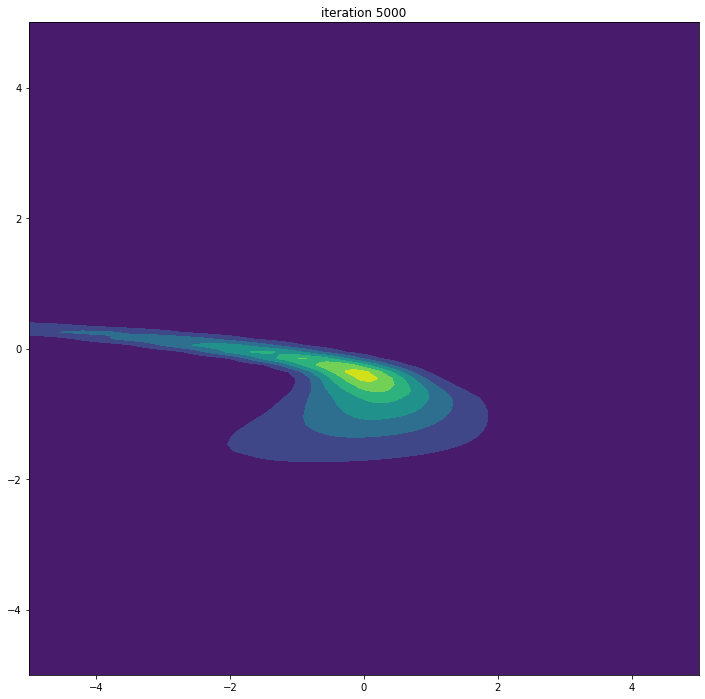

iteration: 5100, loss: tensor(0.1766, grad_fn=<MeanBackward0>)
iteration: 5200, loss: tensor(0.1542, grad_fn=<MeanBackward0>)
iteration: 5300, loss: tensor(0.1496, grad_fn=<MeanBackward0>)
iteration: 5400, loss: tensor(0.1471, grad_fn=<MeanBackward0>)
iteration: 5500, loss: tensor(0.1532, grad_fn=<MeanBackward0>)


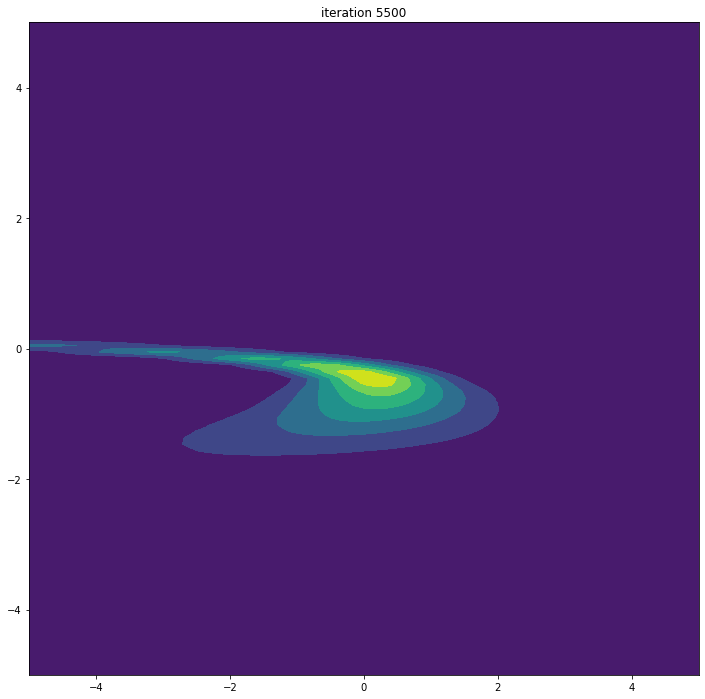

iteration: 5600, loss: tensor(0.1351, grad_fn=<MeanBackward0>)
iteration: 5700, loss: tensor(0.1135, grad_fn=<MeanBackward0>)
iteration: 5800, loss: tensor(0.1224, grad_fn=<MeanBackward0>)
iteration: 5900, loss: tensor(0.1768, grad_fn=<MeanBackward0>)
iteration: 6000, loss: tensor(0.1393, grad_fn=<MeanBackward0>)


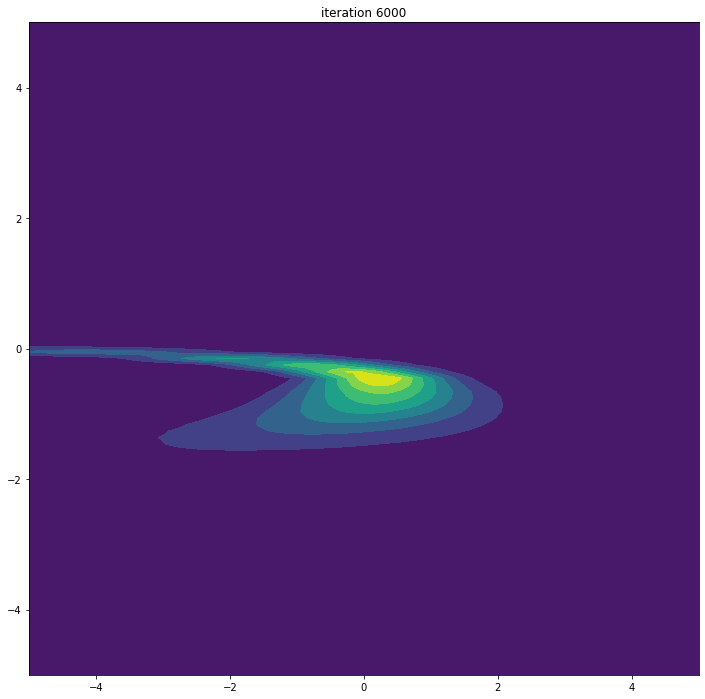

iteration: 6100, loss: tensor(0.1172, grad_fn=<MeanBackward0>)
iteration: 6200, loss: tensor(0.1682, grad_fn=<MeanBackward0>)
iteration: 6300, loss: tensor(0.1256, grad_fn=<MeanBackward0>)
iteration: 6400, loss: tensor(0.1267, grad_fn=<MeanBackward0>)
iteration: 6500, loss: tensor(0.1253, grad_fn=<MeanBackward0>)


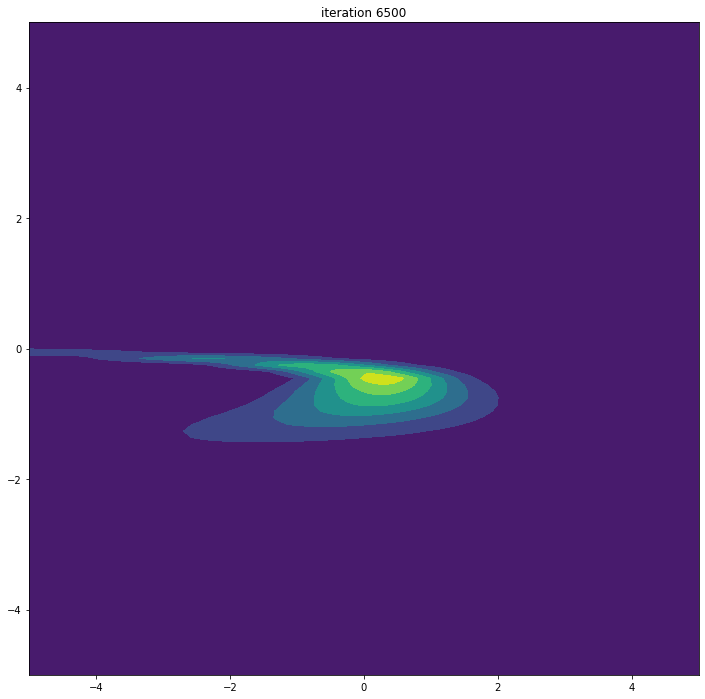

iteration: 6600, loss: tensor(0.1056, grad_fn=<MeanBackward0>)
iteration: 6700, loss: tensor(0.1295, grad_fn=<MeanBackward0>)
iteration: 6800, loss: tensor(0.1219, grad_fn=<MeanBackward0>)
iteration: 6900, loss: tensor(0.1254, grad_fn=<MeanBackward0>)
iteration: 7000, loss: tensor(0.1105, grad_fn=<MeanBackward0>)


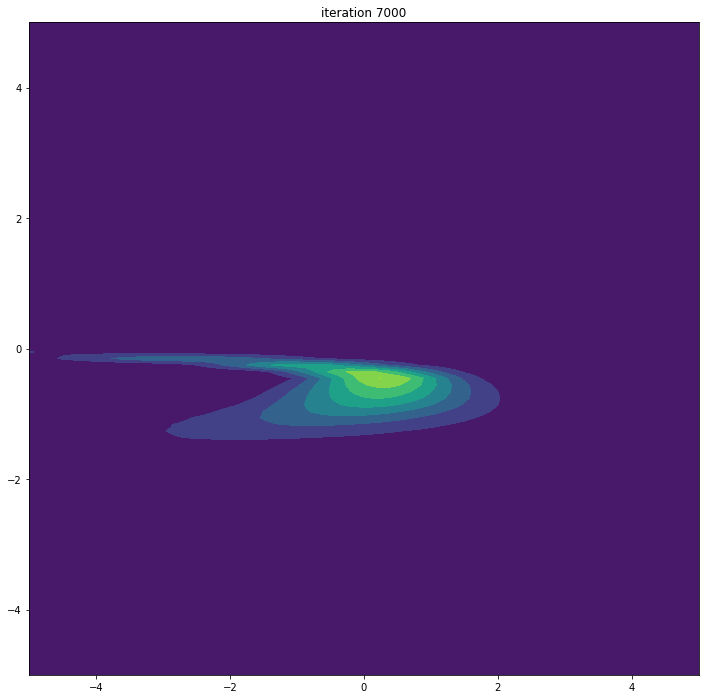

iteration: 7100, loss: tensor(0.1038, grad_fn=<MeanBackward0>)
iteration: 7200, loss: tensor(0.1392, grad_fn=<MeanBackward0>)
iteration: 7300, loss: tensor(0.1108, grad_fn=<MeanBackward0>)
iteration: 7400, loss: tensor(0.1096, grad_fn=<MeanBackward0>)
iteration: 7500, loss: tensor(0.1283, grad_fn=<MeanBackward0>)


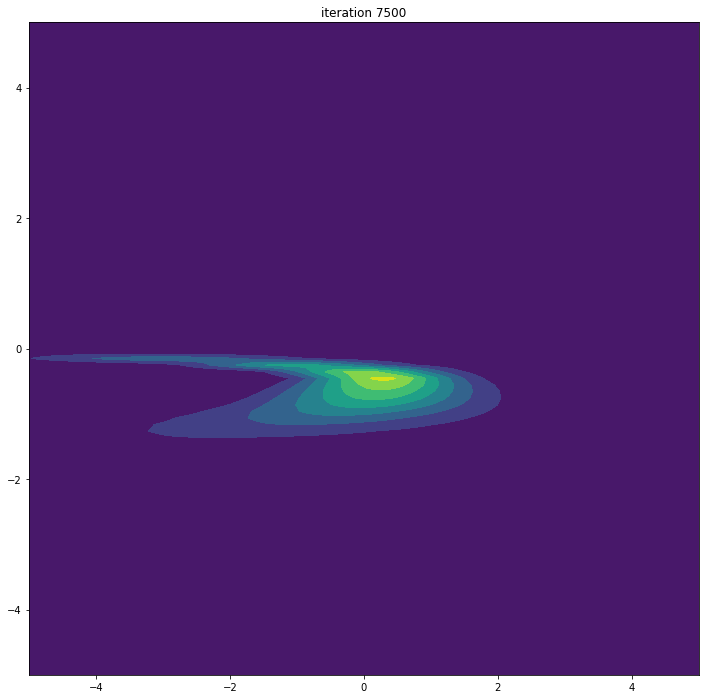

iteration: 7600, loss: tensor(0.1585, grad_fn=<MeanBackward0>)
iteration: 7700, loss: tensor(0.1178, grad_fn=<MeanBackward0>)
iteration: 7800, loss: tensor(0.1013, grad_fn=<MeanBackward0>)
iteration: 7900, loss: tensor(0.0993, grad_fn=<MeanBackward0>)
iteration: 8000, loss: tensor(0.1030, grad_fn=<MeanBackward0>)


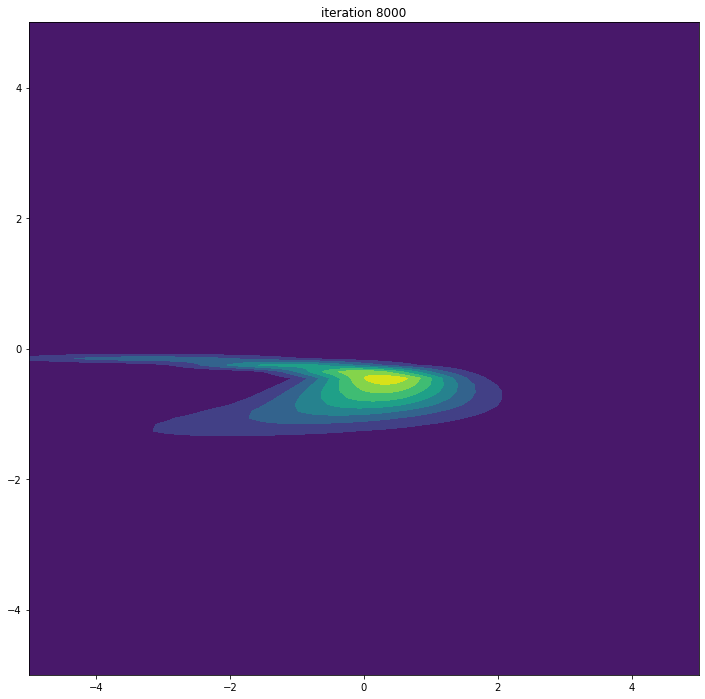

iteration: 8100, loss: tensor(0.1305, grad_fn=<MeanBackward0>)
iteration: 8200, loss: tensor(0.1173, grad_fn=<MeanBackward0>)
iteration: 8300, loss: tensor(0.0963, grad_fn=<MeanBackward0>)
iteration: 8400, loss: tensor(0.1066, grad_fn=<MeanBackward0>)
iteration: 8500, loss: tensor(0.0984, grad_fn=<MeanBackward0>)


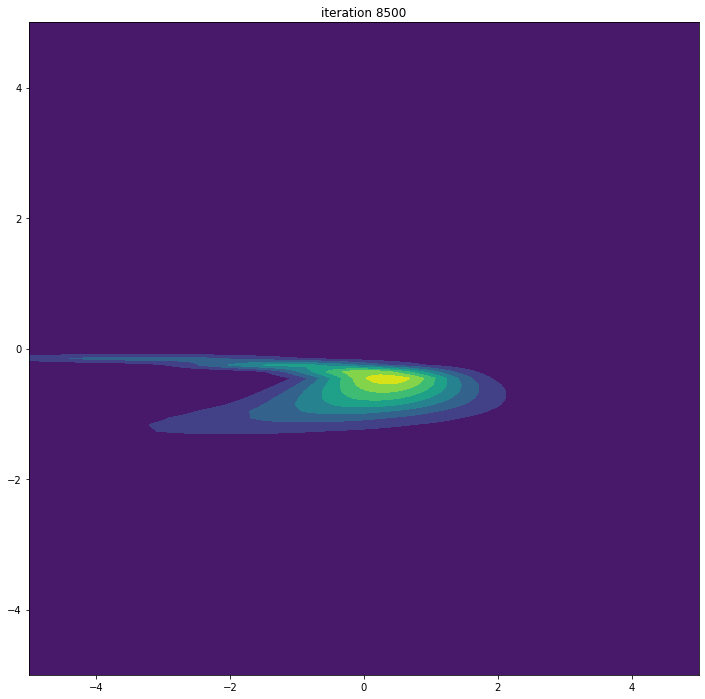

iteration: 8600, loss: tensor(0.0983, grad_fn=<MeanBackward0>)
iteration: 8700, loss: tensor(0.1019, grad_fn=<MeanBackward0>)
iteration: 8800, loss: tensor(0.1089, grad_fn=<MeanBackward0>)
iteration: 8900, loss: tensor(0.1021, grad_fn=<MeanBackward0>)
iteration: 9000, loss: tensor(0.0970, grad_fn=<MeanBackward0>)


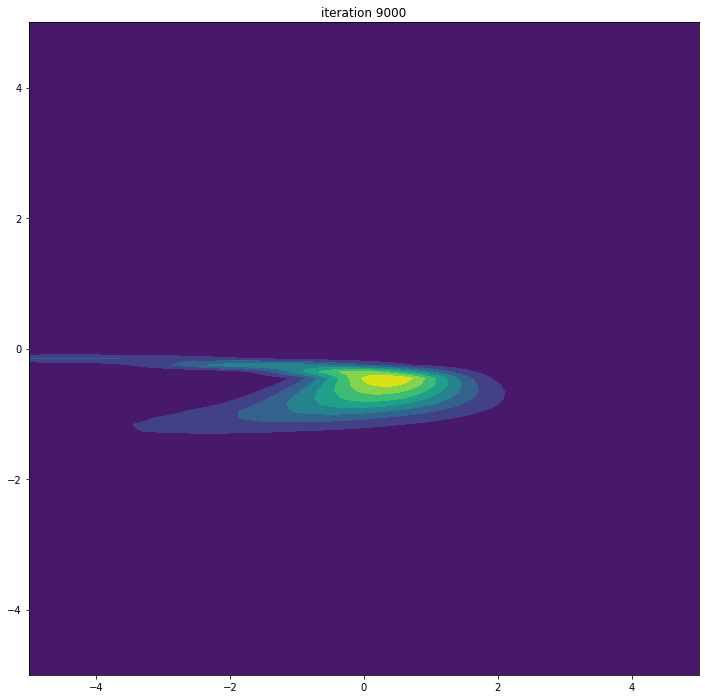

iteration: 9100, loss: tensor(0.1130, grad_fn=<MeanBackward0>)
iteration: 9200, loss: tensor(0.1198, grad_fn=<MeanBackward0>)
iteration: 9300, loss: tensor(0.0958, grad_fn=<MeanBackward0>)
iteration: 9400, loss: tensor(0.1082, grad_fn=<MeanBackward0>)
iteration: 9500, loss: tensor(0.1179, grad_fn=<MeanBackward0>)


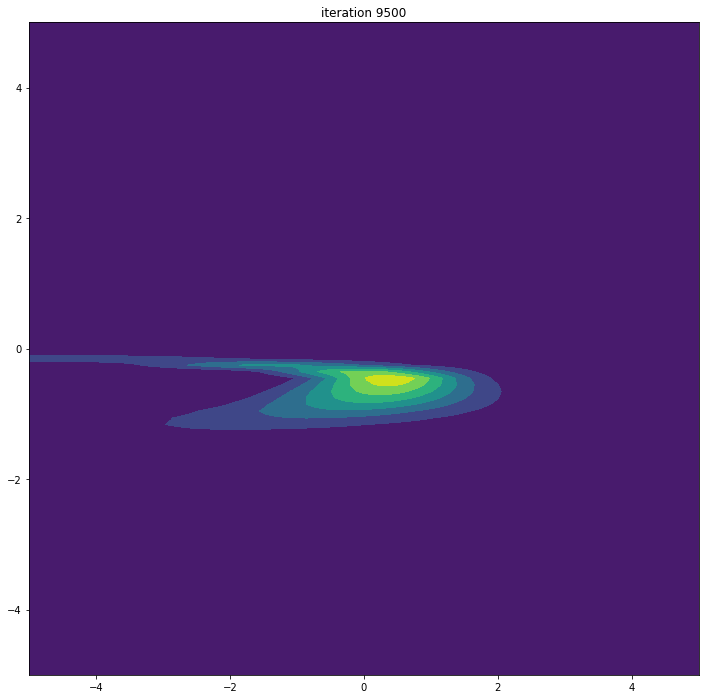

iteration: 9600, loss: tensor(0.1010, grad_fn=<MeanBackward0>)
iteration: 9700, loss: tensor(0.0886, grad_fn=<MeanBackward0>)
iteration: 9800, loss: tensor(0.0928, grad_fn=<MeanBackward0>)
iteration: 9900, loss: tensor(0.1178, grad_fn=<MeanBackward0>)
iteration: 10000, loss: tensor(0.0901, grad_fn=<MeanBackward0>)


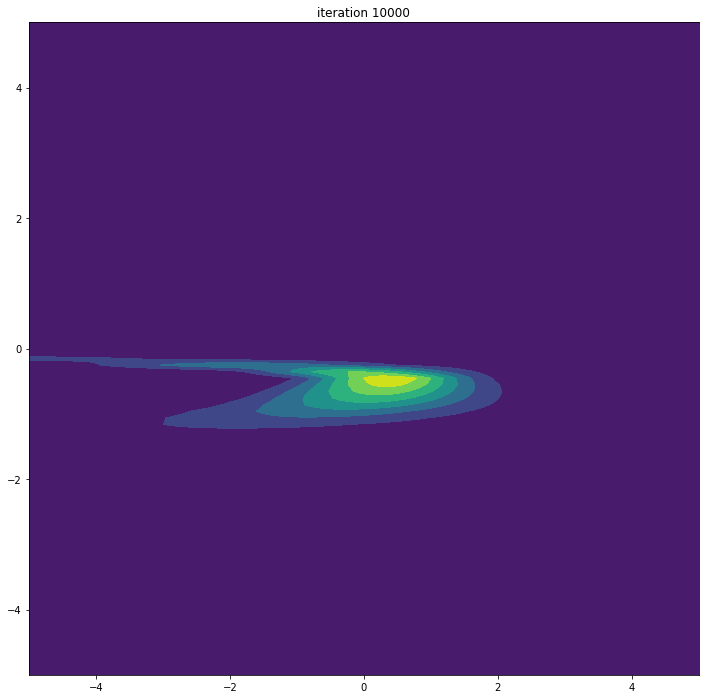

In [413]:
num_iter = 10000
for i in range(num_iter):
    N = 100 # 100 samples from base distribution
    x = base_dist.sample(N)

    optimizer.zero_grad()
    t_x = flow._transform(x)[0]

    loss = loss_KSD(t_x,banana_test)
    if (i + 1) % 100 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-5,5)
        yline = torch.linspace(-5,5)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

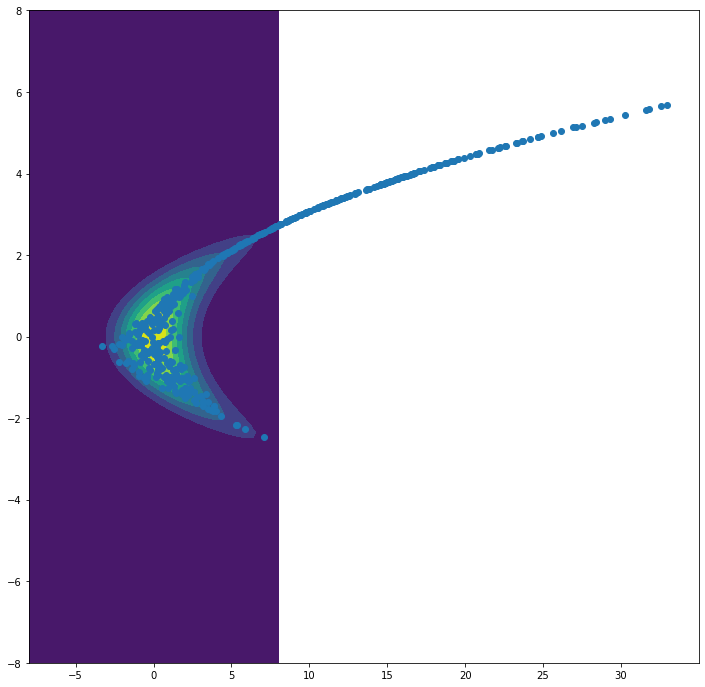

In [414]:
plot_banana(a,v1,v2)

test = base_dist.sample(500)
t_test = flow._transform(test)[0]
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1])

plt.show()

### Masked Piecewise Rational Quadratic Flow

The following uses Masked Piecewise Rational Quadratic Flow used in (https://arxiv.org/pdf/1906.04032.pdf).

In [418]:
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.nonlinearities import Sigmoid
from nflows.transforms.nonlinearities import Logit

num_layers = 2
base_dist = StandardNormal(shape=[2]) 

transforms = []
for _ in range(num_layers):
    transforms.append(Sigmoid())
    transforms.append(MaskedPiecewiseCubicAutoregressiveTransform(num_bins = 10,features=2, 
                                                          hidden_features=4))
    transforms.append(Logit())
    
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist) #This base distribution is not needed for variation inference
optimizer = optim.Adam(flow.parameters())

iteration: 100, loss: tensor(0.4562, grad_fn=<MeanBackward0>)
iteration: 200, loss: tensor(0.4075, grad_fn=<MeanBackward0>)
iteration: 300, loss: tensor(0.3200, grad_fn=<MeanBackward0>)
iteration: 400, loss: tensor(0.4328, grad_fn=<MeanBackward0>)
iteration: 500, loss: tensor(0.3325, grad_fn=<MeanBackward0>)


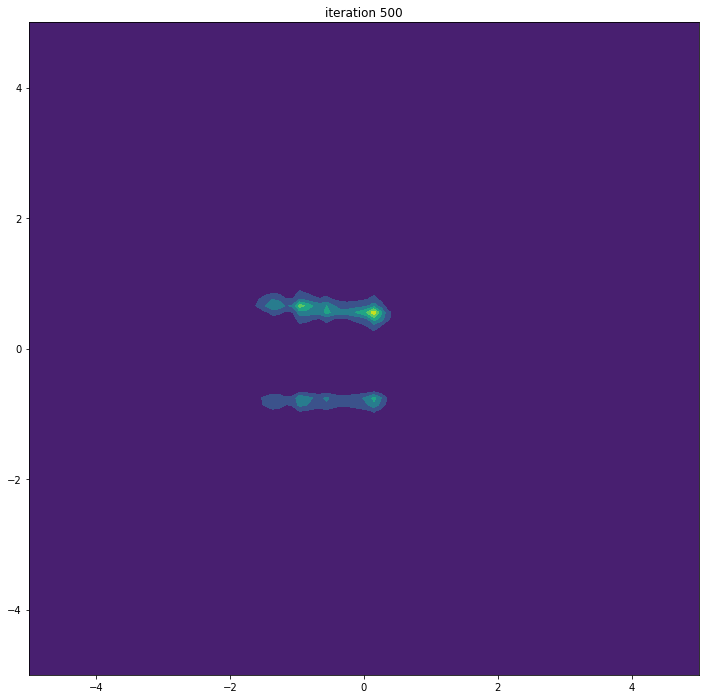

iteration: 600, loss: tensor(0.2837, grad_fn=<MeanBackward0>)
iteration: 700, loss: tensor(0.2964, grad_fn=<MeanBackward0>)
iteration: 800, loss: tensor(0.3412, grad_fn=<MeanBackward0>)
iteration: 900, loss: tensor(0.2866, grad_fn=<MeanBackward0>)
iteration: 1000, loss: tensor(0.2748, grad_fn=<MeanBackward0>)


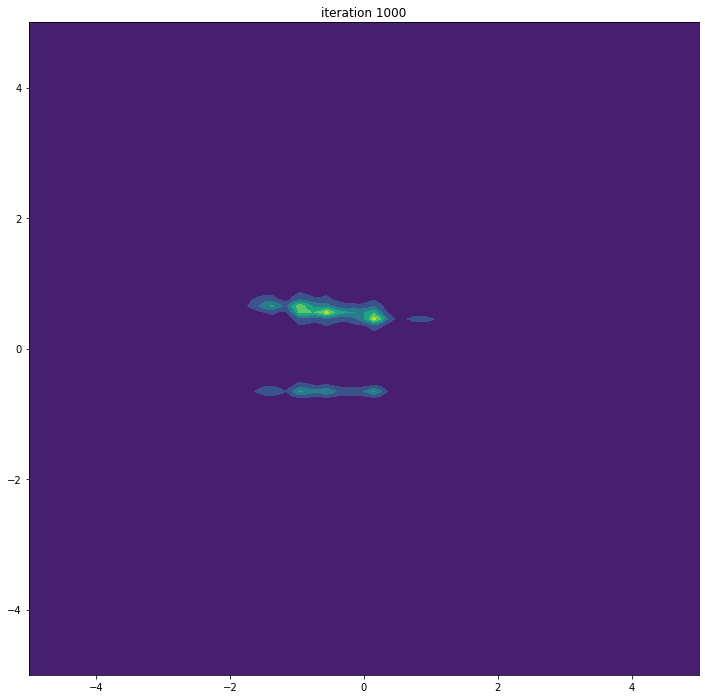

iteration: 1100, loss: tensor(0.3300, grad_fn=<MeanBackward0>)
iteration: 1200, loss: tensor(0.2571, grad_fn=<MeanBackward0>)
iteration: 1300, loss: tensor(0.3626, grad_fn=<MeanBackward0>)
iteration: 1400, loss: tensor(0.2429, grad_fn=<MeanBackward0>)
iteration: 1500, loss: tensor(0.2645, grad_fn=<MeanBackward0>)


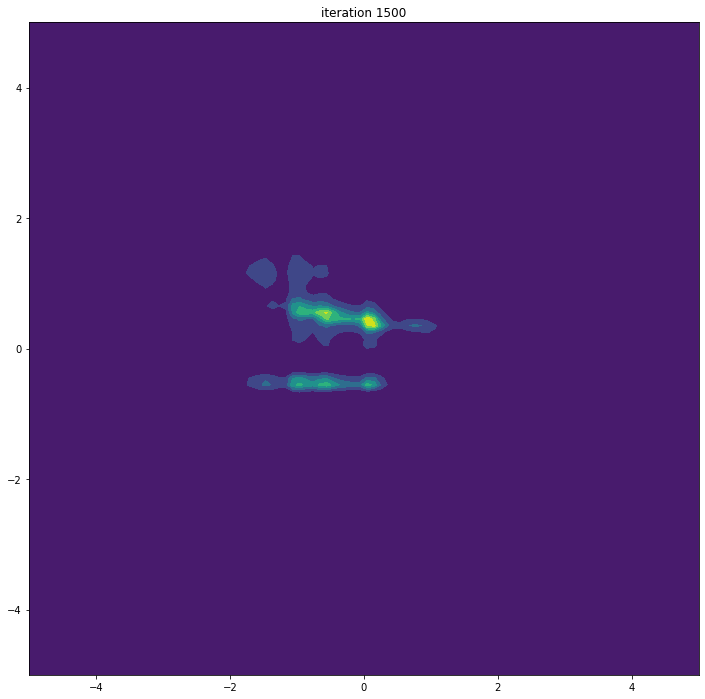

iteration: 1600, loss: tensor(0.2453, grad_fn=<MeanBackward0>)
iteration: 1700, loss: tensor(0.2286, grad_fn=<MeanBackward0>)
iteration: 1800, loss: tensor(0.2204, grad_fn=<MeanBackward0>)
iteration: 1900, loss: tensor(0.2180, grad_fn=<MeanBackward0>)
iteration: 2000, loss: tensor(0.2257, grad_fn=<MeanBackward0>)


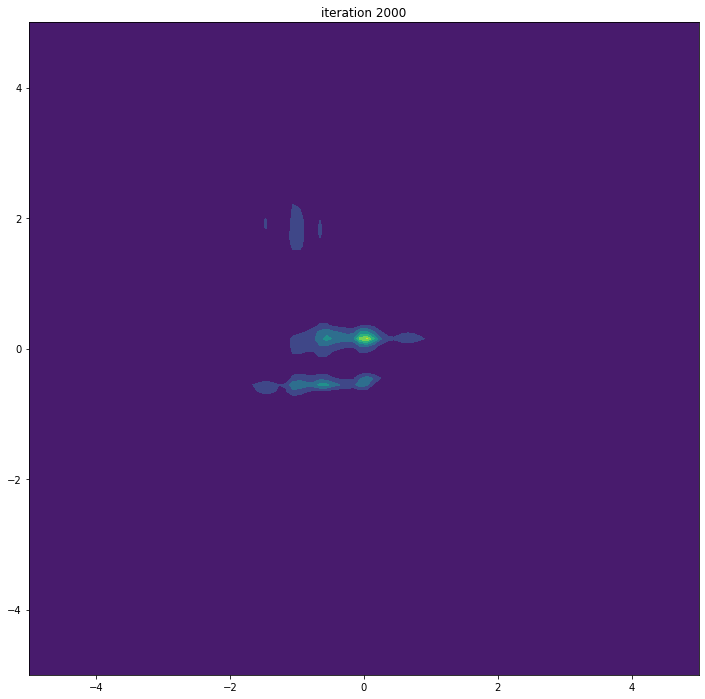

iteration: 2100, loss: tensor(0.1995, grad_fn=<MeanBackward0>)
iteration: 2200, loss: tensor(0.1768, grad_fn=<MeanBackward0>)
iteration: 2300, loss: tensor(0.2224, grad_fn=<MeanBackward0>)
iteration: 2400, loss: tensor(0.1764, grad_fn=<MeanBackward0>)
iteration: 2500, loss: tensor(0.2320, grad_fn=<MeanBackward0>)


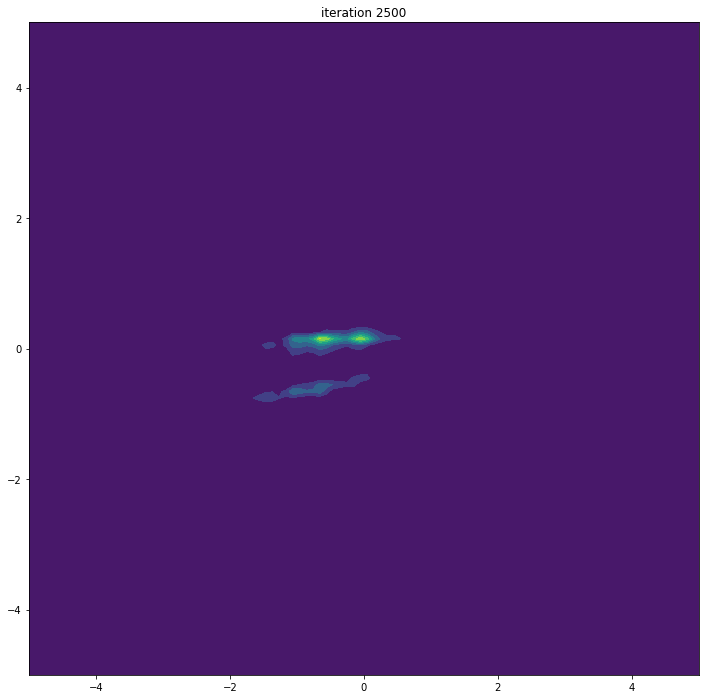

iteration: 2600, loss: tensor(0.1670, grad_fn=<MeanBackward0>)
iteration: 2700, loss: tensor(0.1775, grad_fn=<MeanBackward0>)
iteration: 2800, loss: tensor(0.1792, grad_fn=<MeanBackward0>)
iteration: 2900, loss: tensor(0.1723, grad_fn=<MeanBackward0>)
iteration: 3000, loss: tensor(0.1926, grad_fn=<MeanBackward0>)


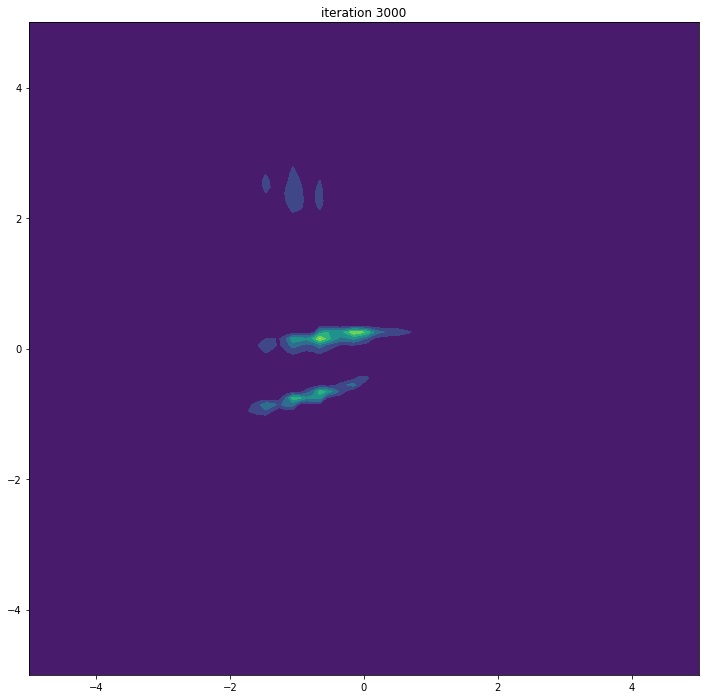

iteration: 3100, loss: tensor(0.1648, grad_fn=<MeanBackward0>)
iteration: 3200, loss: tensor(0.1671, grad_fn=<MeanBackward0>)
iteration: 3300, loss: tensor(0.1692, grad_fn=<MeanBackward0>)
iteration: 3400, loss: tensor(0.1670, grad_fn=<MeanBackward0>)
iteration: 3500, loss: tensor(0.1627, grad_fn=<MeanBackward0>)


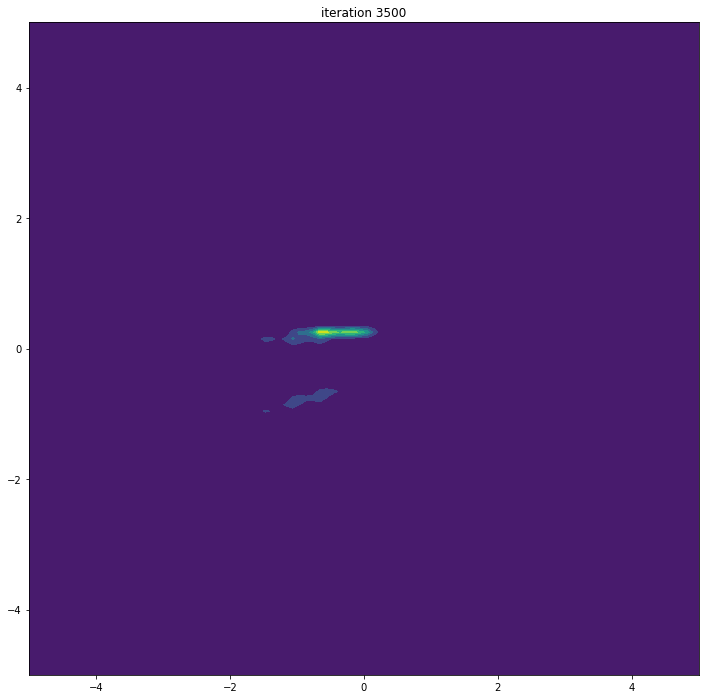

iteration: 3600, loss: tensor(0.1634, grad_fn=<MeanBackward0>)
iteration: 3700, loss: tensor(0.1665, grad_fn=<MeanBackward0>)
iteration: 3800, loss: tensor(0.2800, grad_fn=<MeanBackward0>)
iteration: 3900, loss: tensor(0.1671, grad_fn=<MeanBackward0>)
iteration: 4000, loss: tensor(0.1509, grad_fn=<MeanBackward0>)


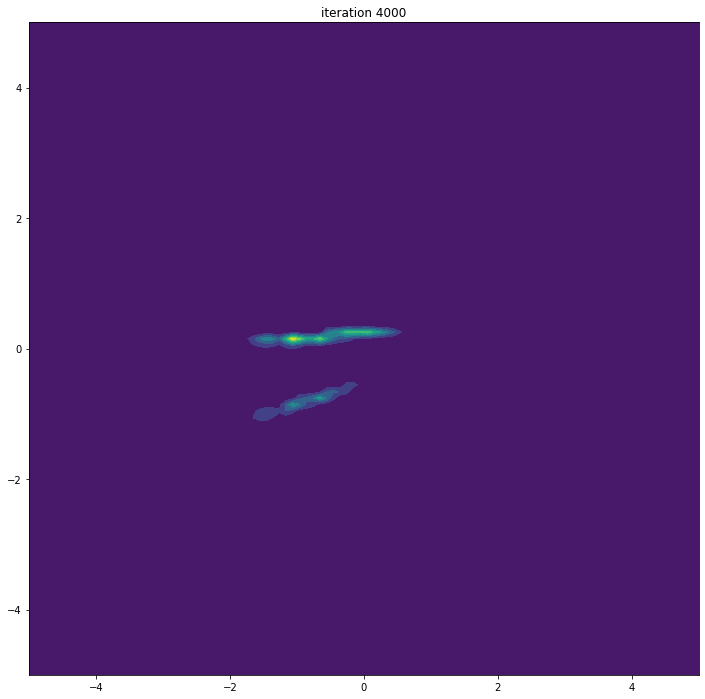

iteration: 4100, loss: tensor(0.1973, grad_fn=<MeanBackward0>)
iteration: 4200, loss: tensor(0.1510, grad_fn=<MeanBackward0>)
iteration: 4300, loss: tensor(0.1416, grad_fn=<MeanBackward0>)
iteration: 4400, loss: tensor(0.1780, grad_fn=<MeanBackward0>)
iteration: 4500, loss: tensor(0.1542, grad_fn=<MeanBackward0>)


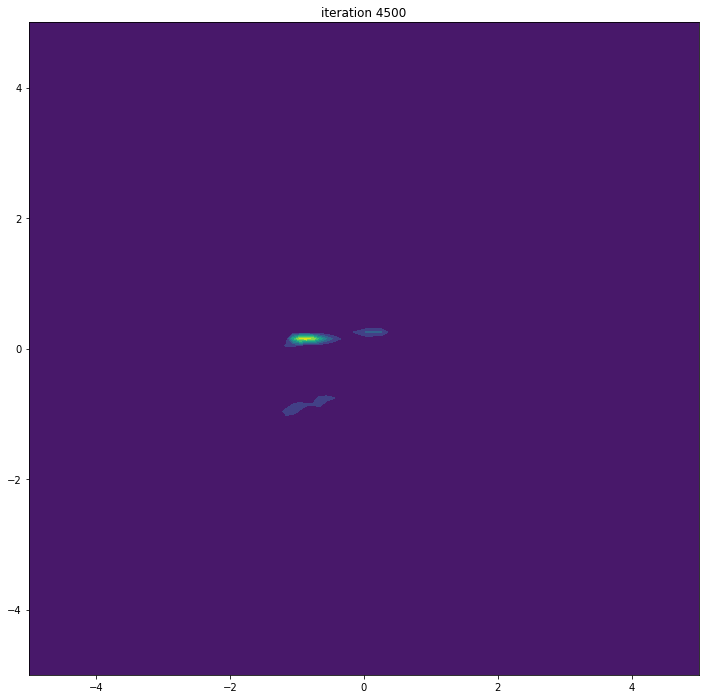

iteration: 4600, loss: tensor(0.1553, grad_fn=<MeanBackward0>)
iteration: 4700, loss: tensor(0.1530, grad_fn=<MeanBackward0>)
iteration: 4800, loss: tensor(0.1660, grad_fn=<MeanBackward0>)
iteration: 4900, loss: tensor(0.1788, grad_fn=<MeanBackward0>)
iteration: 5000, loss: tensor(0.1647, grad_fn=<MeanBackward0>)


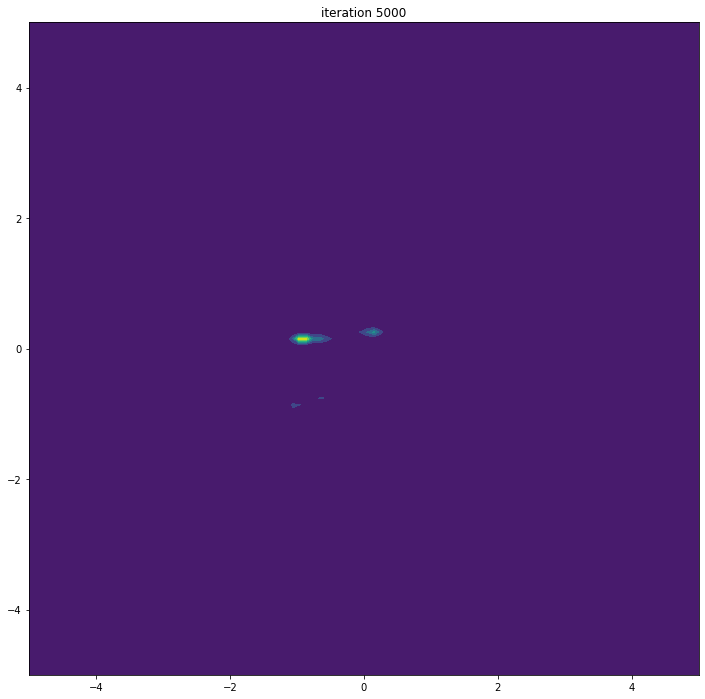

iteration: 5100, loss: tensor(0.1603, grad_fn=<MeanBackward0>)
iteration: 5200, loss: tensor(0.1776, grad_fn=<MeanBackward0>)
iteration: 5300, loss: tensor(0.1475, grad_fn=<MeanBackward0>)
iteration: 5400, loss: tensor(0.1634, grad_fn=<MeanBackward0>)
iteration: 5500, loss: tensor(0.1706, grad_fn=<MeanBackward0>)


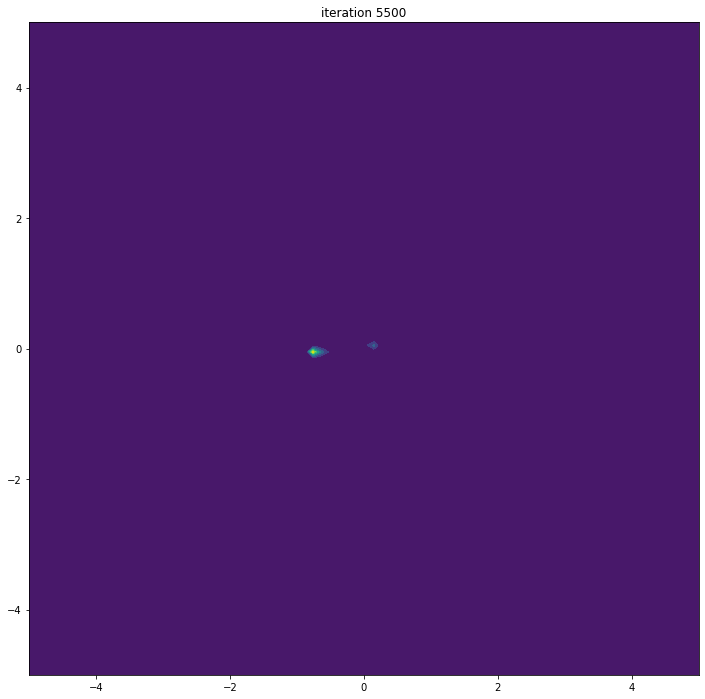

iteration: 5600, loss: tensor(0.1625, grad_fn=<MeanBackward0>)
iteration: 5700, loss: tensor(0.1800, grad_fn=<MeanBackward0>)
iteration: 5800, loss: tensor(0.1748, grad_fn=<MeanBackward0>)
iteration: 5900, loss: tensor(0.1379, grad_fn=<MeanBackward0>)
iteration: 6000, loss: tensor(0.1541, grad_fn=<MeanBackward0>)


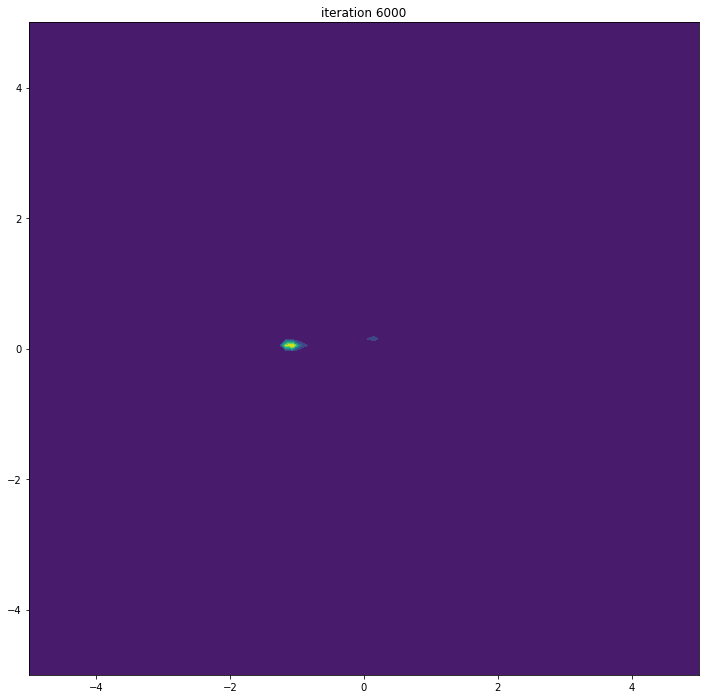

iteration: 6100, loss: tensor(0.1430, grad_fn=<MeanBackward0>)
iteration: 6200, loss: tensor(0.1584, grad_fn=<MeanBackward0>)
iteration: 6300, loss: tensor(0.1509, grad_fn=<MeanBackward0>)
iteration: 6400, loss: tensor(0.1558, grad_fn=<MeanBackward0>)
iteration: 6500, loss: tensor(0.1540, grad_fn=<MeanBackward0>)


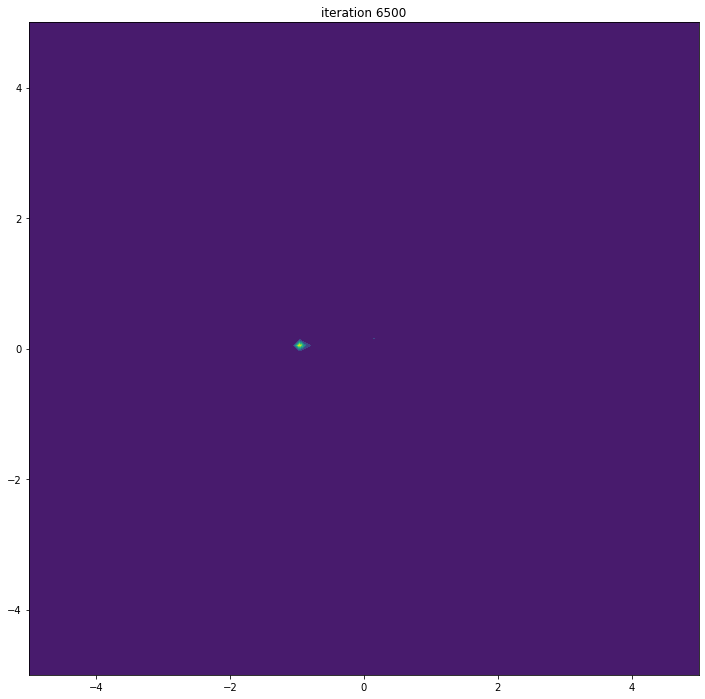

iteration: 6600, loss: tensor(0.1629, grad_fn=<MeanBackward0>)
iteration: 6700, loss: tensor(0.1475, grad_fn=<MeanBackward0>)
iteration: 6800, loss: tensor(0.1628, grad_fn=<MeanBackward0>)
iteration: 6900, loss: tensor(0.1786, grad_fn=<MeanBackward0>)
iteration: 7000, loss: tensor(0.1539, grad_fn=<MeanBackward0>)


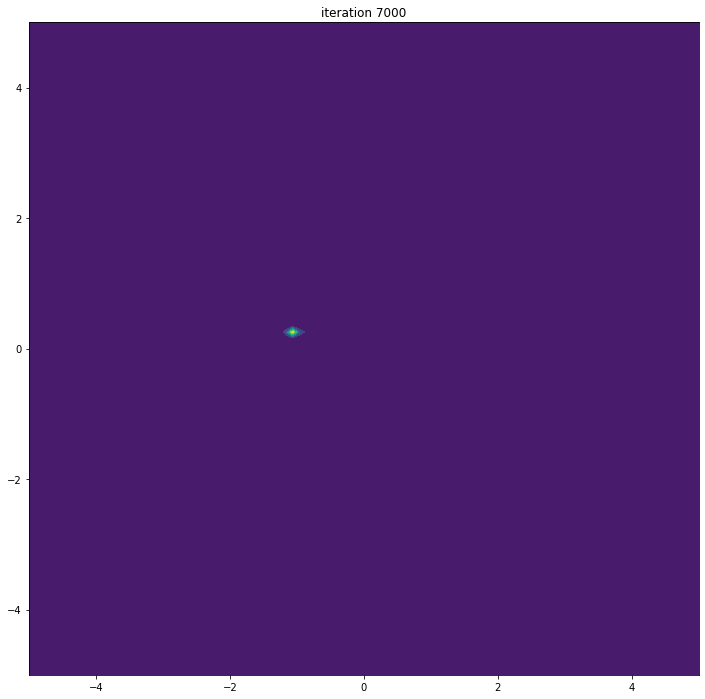

iteration: 7100, loss: tensor(0.1393, grad_fn=<MeanBackward0>)
iteration: 7200, loss: tensor(0.1625, grad_fn=<MeanBackward0>)
iteration: 7300, loss: tensor(0.1419, grad_fn=<MeanBackward0>)
iteration: 7400, loss: tensor(0.1345, grad_fn=<MeanBackward0>)
iteration: 7500, loss: tensor(0.1440, grad_fn=<MeanBackward0>)


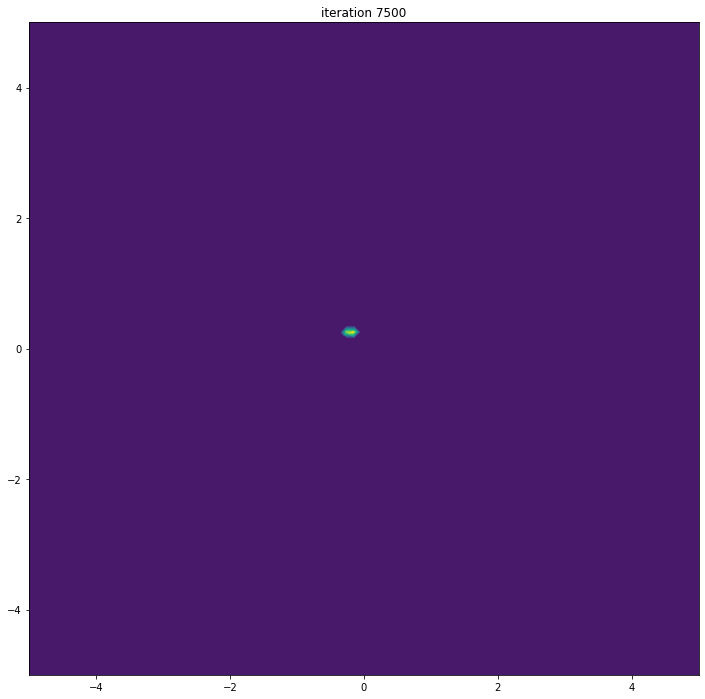

iteration: 7600, loss: tensor(0.1605, grad_fn=<MeanBackward0>)
iteration: 7700, loss: tensor(0.1449, grad_fn=<MeanBackward0>)
iteration: 7800, loss: tensor(0.1292, grad_fn=<MeanBackward0>)
iteration: 7900, loss: tensor(0.1425, grad_fn=<MeanBackward0>)
iteration: 8000, loss: tensor(0.1323, grad_fn=<MeanBackward0>)


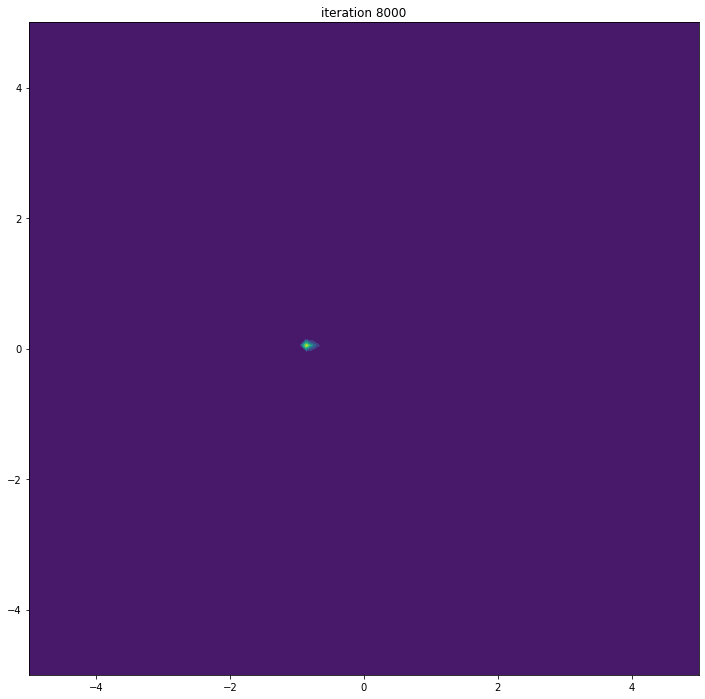

iteration: 8100, loss: tensor(0.1553, grad_fn=<MeanBackward0>)
iteration: 8200, loss: tensor(0.1466, grad_fn=<MeanBackward0>)
iteration: 8300, loss: tensor(0.1395, grad_fn=<MeanBackward0>)
iteration: 8400, loss: tensor(0.1271, grad_fn=<MeanBackward0>)
iteration: 8500, loss: tensor(0.1531, grad_fn=<MeanBackward0>)


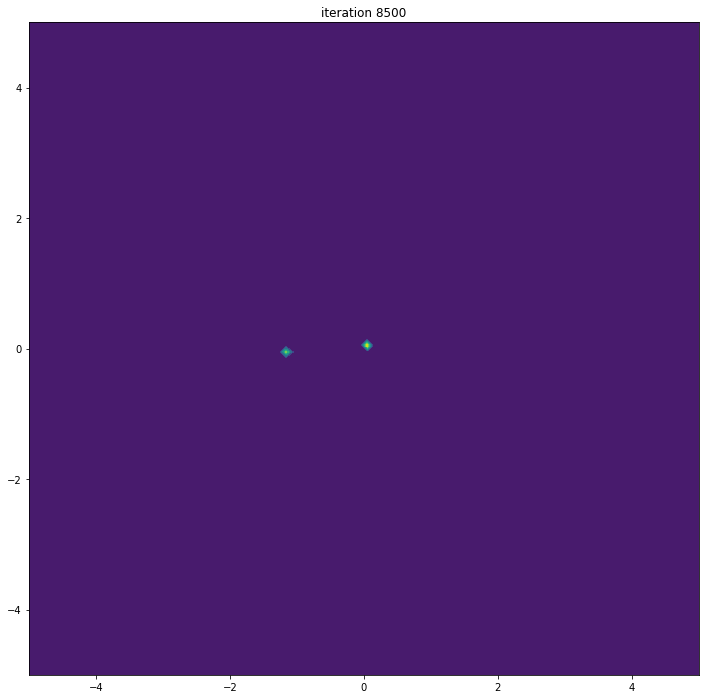

iteration: 8600, loss: tensor(0.1513, grad_fn=<MeanBackward0>)
iteration: 8700, loss: tensor(0.1271, grad_fn=<MeanBackward0>)
iteration: 8800, loss: tensor(0.1451, grad_fn=<MeanBackward0>)
iteration: 8900, loss: tensor(0.1347, grad_fn=<MeanBackward0>)
iteration: 9000, loss: tensor(0.1397, grad_fn=<MeanBackward0>)


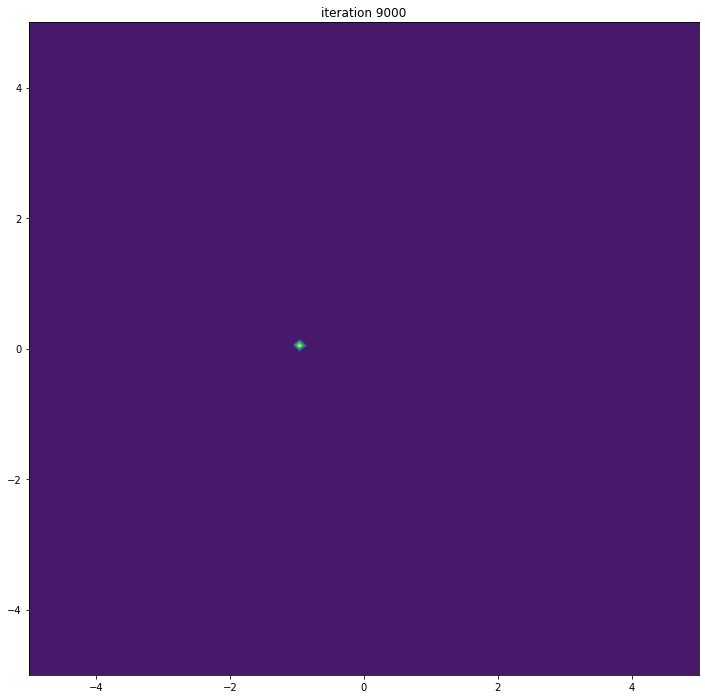

iteration: 9100, loss: tensor(0.1390, grad_fn=<MeanBackward0>)
iteration: 9200, loss: tensor(0.1451, grad_fn=<MeanBackward0>)
iteration: 9300, loss: tensor(0.1437, grad_fn=<MeanBackward0>)
iteration: 9400, loss: tensor(0.1306, grad_fn=<MeanBackward0>)
iteration: 9500, loss: tensor(0.1552, grad_fn=<MeanBackward0>)


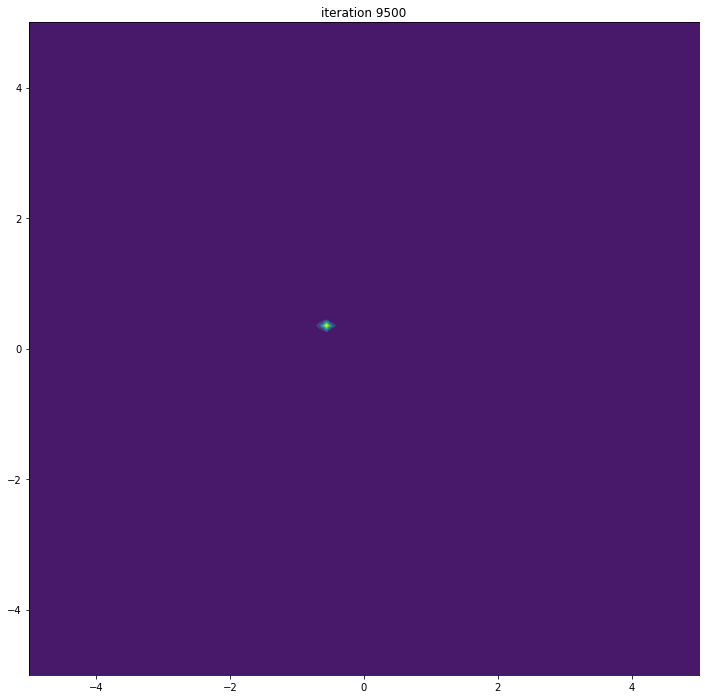

iteration: 9600, loss: tensor(0.1437, grad_fn=<MeanBackward0>)
iteration: 9700, loss: tensor(0.1356, grad_fn=<MeanBackward0>)
iteration: 9800, loss: tensor(0.1460, grad_fn=<MeanBackward0>)
iteration: 9900, loss: tensor(0.1314, grad_fn=<MeanBackward0>)
iteration: 10000, loss: tensor(0.1264, grad_fn=<MeanBackward0>)


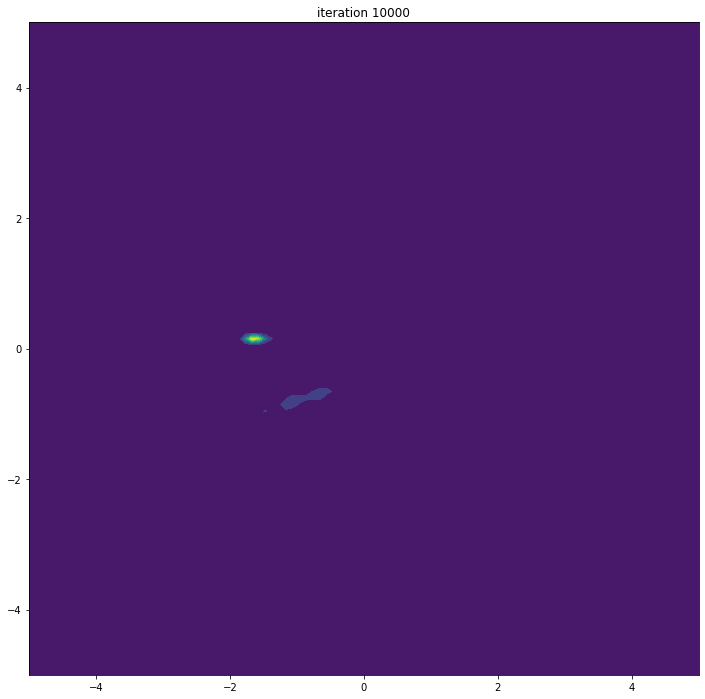

In [419]:
num_iter = 10000
for i in range(num_iter):
    N = 100 # 100 samples from base distribution
    x = base_dist.sample(N)

    optimizer.zero_grad()
    t_x = flow._transform(x)[0]

    loss = loss_KSD(t_x,banana_test)
    if (i + 1) % 100 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-5,5)
        yline = torch.linspace(-5,5)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()

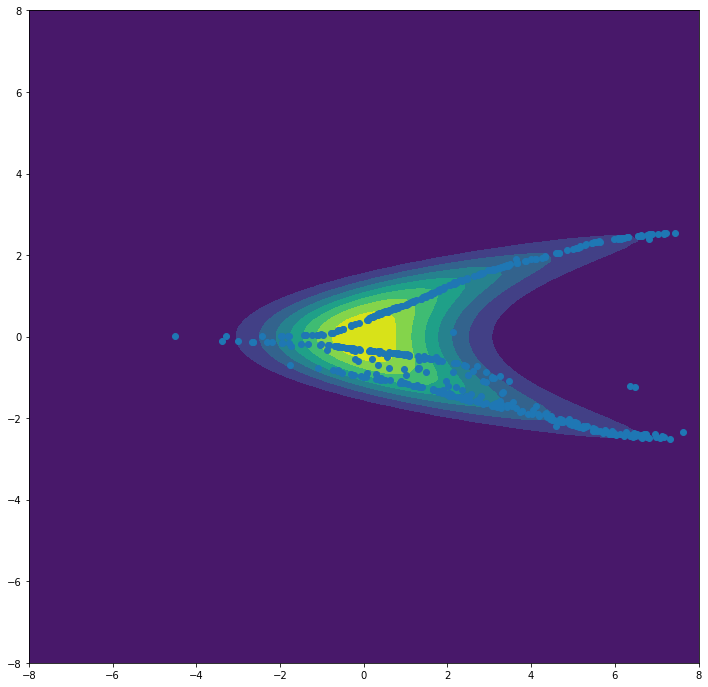

In [422]:
plot_banana(a,v1,v2)

test = base_dist.sample(500)
t_test = flow._transform(test)[0]
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1])

plt.show()

### Mixture of Gaussians target

The following is a Masked Autoregressive Flow for Density Estimation from (https://arxiv.org/pdf/1705.07057.pdf).

In [427]:
num_layers = 5
base_dist = StandardNormal(shape=[2])

transforms = []
for _ in range(num_layers):
    transforms.append(ReversePermutation(features=2))
    transforms.append(MaskedAffineAutoregressiveTransform(features=2, 
                                                          hidden_features=4))
transform = CompositeTransform(transforms)

flow = Flow(transform, base_dist)
optimizer = optim.Adam(flow.parameters())

In [428]:
m1 = torch.Tensor([-3,0])
g1 = torch.distributions.multivariate_normal.MultivariateNormal(m1,torch.eye(2))

m2 = torch.Tensor([-2,-1])
g2 = torch.distributions.multivariate_normal.MultivariateNormal(m2,torch.eye(2))

m3 = torch.Tensor([-2,1])
g3 = torch.distributions.multivariate_normal.MultivariateNormal(m3,torch.eye(2))

m4 = torch.Tensor([-1,-2])
g4 = torch.distributions.multivariate_normal.MultivariateNormal(m4,torch.eye(2))

m5 = torch.Tensor([-1,2])
g5 = torch.distributions.multivariate_normal.MultivariateNormal(m5,torch.eye(2))

MOG = [g1,g2,g3,g4,g5]

score_mix = lambda x: score_mixture_gauss(x,MOG)

iteration: 100, loss: tensor(0.3195, grad_fn=<MeanBackward0>)
iteration: 200, loss: tensor(0.2015, grad_fn=<MeanBackward0>)
iteration: 300, loss: tensor(0.1004, grad_fn=<MeanBackward0>)
iteration: 400, loss: tensor(0.0508, grad_fn=<MeanBackward0>)
iteration: 500, loss: tensor(0.0475, grad_fn=<MeanBackward0>)


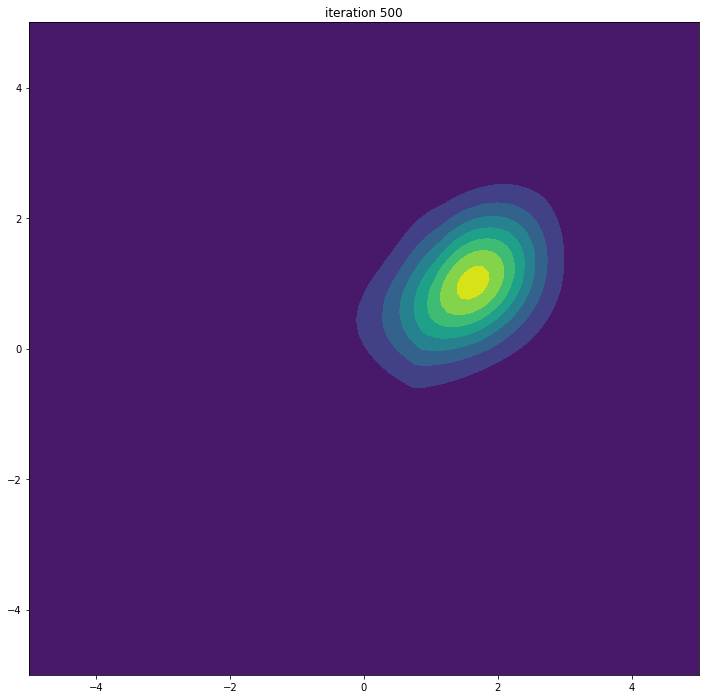

iteration: 600, loss: tensor(0.0495, grad_fn=<MeanBackward0>)
iteration: 700, loss: tensor(0.0485, grad_fn=<MeanBackward0>)
iteration: 800, loss: tensor(0.0332, grad_fn=<MeanBackward0>)
iteration: 900, loss: tensor(0.0289, grad_fn=<MeanBackward0>)
iteration: 1000, loss: tensor(0.0436, grad_fn=<MeanBackward0>)


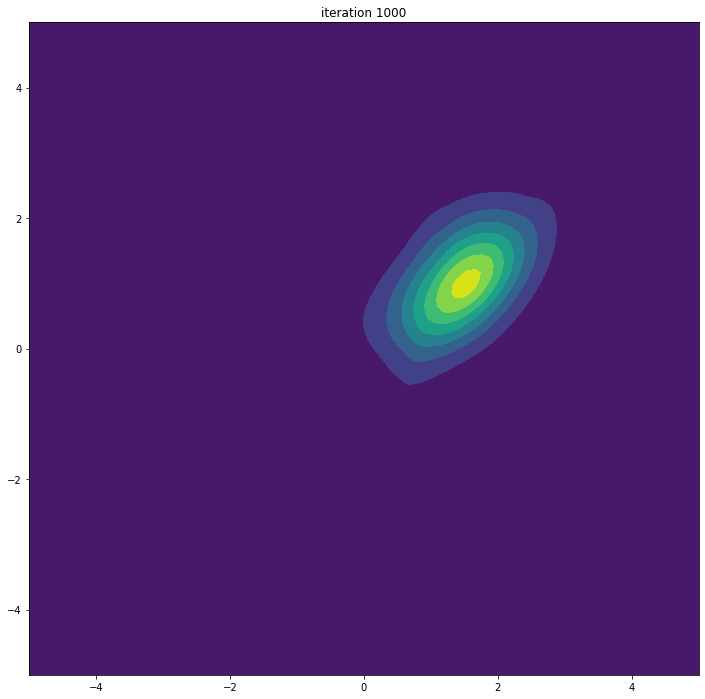

iteration: 1100, loss: tensor(0.0379, grad_fn=<MeanBackward0>)
iteration: 1200, loss: tensor(0.0360, grad_fn=<MeanBackward0>)
iteration: 1300, loss: tensor(0.0340, grad_fn=<MeanBackward0>)
iteration: 1400, loss: tensor(0.0367, grad_fn=<MeanBackward0>)
iteration: 1500, loss: tensor(0.0467, grad_fn=<MeanBackward0>)


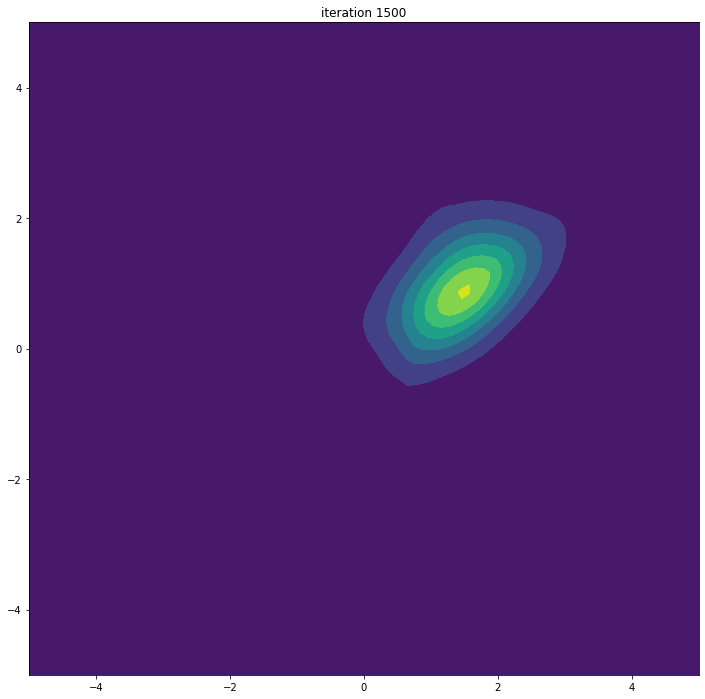

iteration: 1600, loss: tensor(0.0244, grad_fn=<MeanBackward0>)
iteration: 1700, loss: tensor(0.0343, grad_fn=<MeanBackward0>)
iteration: 1800, loss: tensor(0.0485, grad_fn=<MeanBackward0>)
iteration: 1900, loss: tensor(0.0301, grad_fn=<MeanBackward0>)
iteration: 2000, loss: tensor(0.0378, grad_fn=<MeanBackward0>)


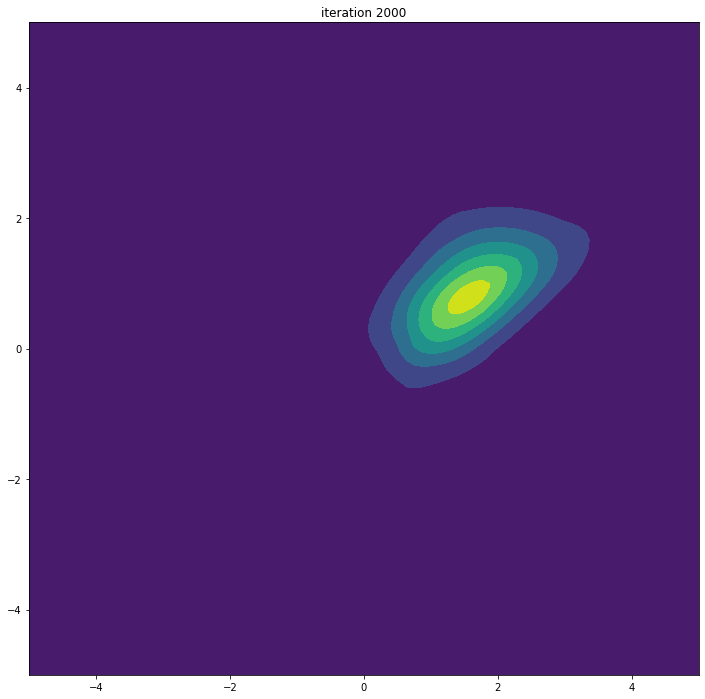

iteration: 2100, loss: tensor(0.0336, grad_fn=<MeanBackward0>)
iteration: 2200, loss: tensor(0.0282, grad_fn=<MeanBackward0>)
iteration: 2300, loss: tensor(0.0248, grad_fn=<MeanBackward0>)
iteration: 2400, loss: tensor(0.0328, grad_fn=<MeanBackward0>)
iteration: 2500, loss: tensor(0.0348, grad_fn=<MeanBackward0>)


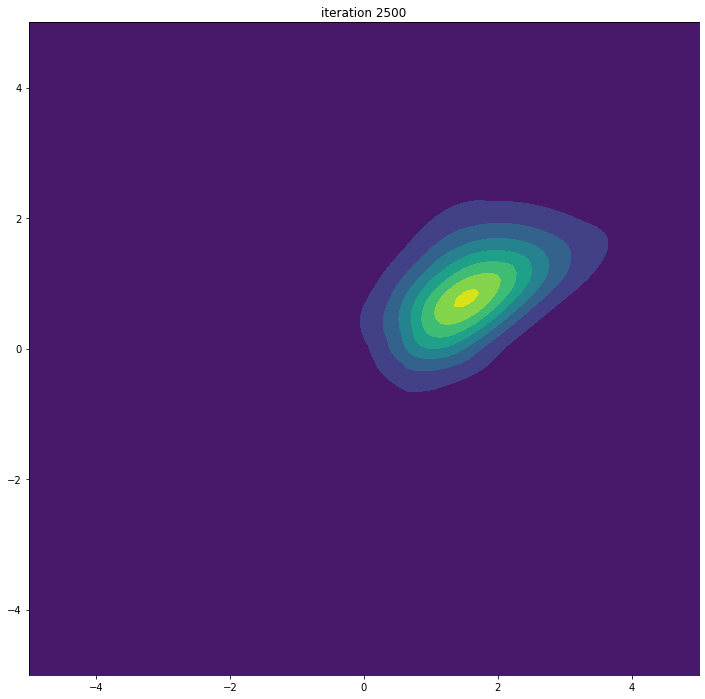

iteration: 2600, loss: tensor(0.0249, grad_fn=<MeanBackward0>)
iteration: 2700, loss: tensor(0.0298, grad_fn=<MeanBackward0>)
iteration: 2800, loss: tensor(0.0278, grad_fn=<MeanBackward0>)
iteration: 2900, loss: tensor(0.0384, grad_fn=<MeanBackward0>)
iteration: 3000, loss: tensor(0.0261, grad_fn=<MeanBackward0>)


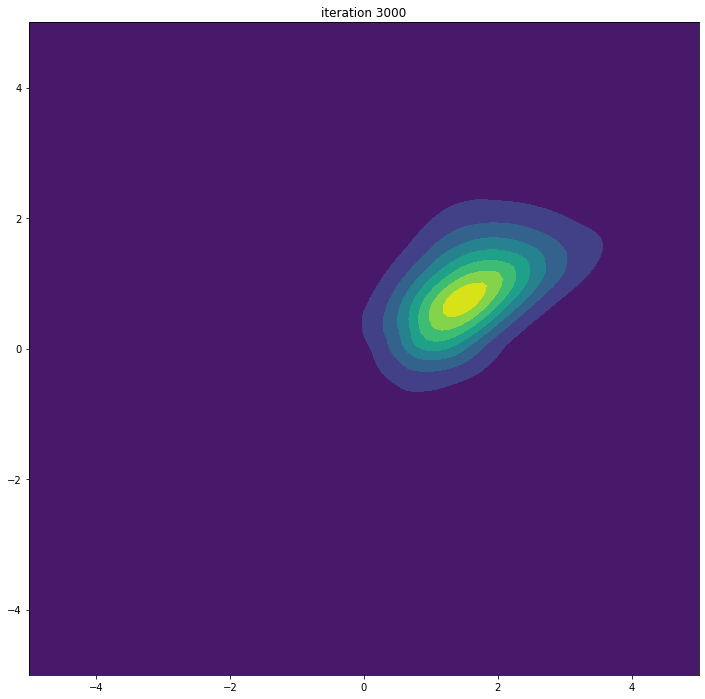

iteration: 3100, loss: tensor(0.0317, grad_fn=<MeanBackward0>)
iteration: 3200, loss: tensor(0.0280, grad_fn=<MeanBackward0>)
iteration: 3300, loss: tensor(0.0346, grad_fn=<MeanBackward0>)
iteration: 3400, loss: tensor(0.0281, grad_fn=<MeanBackward0>)
iteration: 3500, loss: tensor(0.0454, grad_fn=<MeanBackward0>)


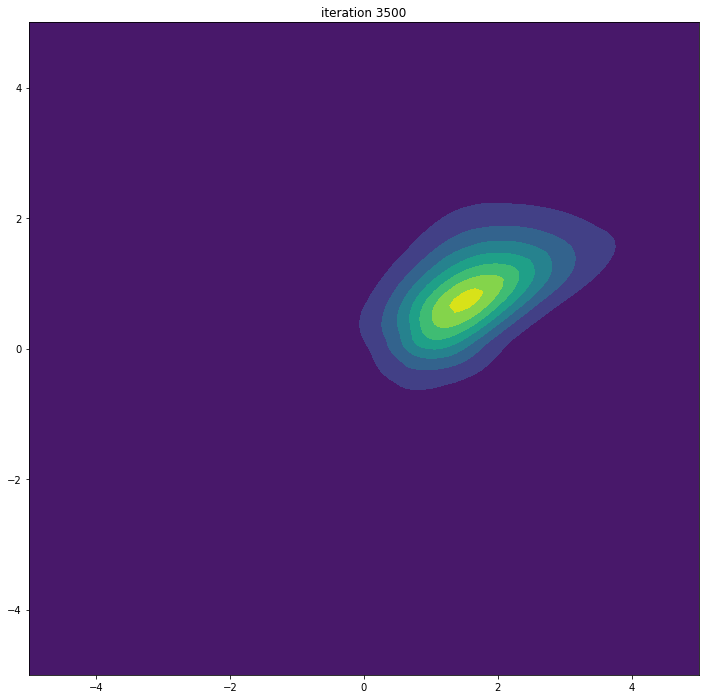

iteration: 3600, loss: tensor(0.0262, grad_fn=<MeanBackward0>)
iteration: 3700, loss: tensor(0.0370, grad_fn=<MeanBackward0>)
iteration: 3800, loss: tensor(0.0329, grad_fn=<MeanBackward0>)
iteration: 3900, loss: tensor(0.0376, grad_fn=<MeanBackward0>)
iteration: 4000, loss: tensor(0.0368, grad_fn=<MeanBackward0>)


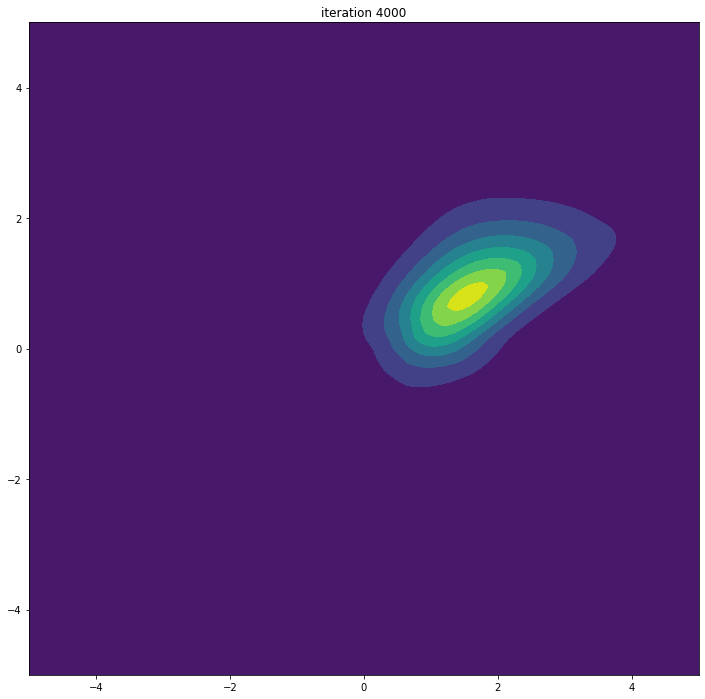

iteration: 4100, loss: tensor(0.0313, grad_fn=<MeanBackward0>)
iteration: 4200, loss: tensor(0.0320, grad_fn=<MeanBackward0>)
iteration: 4300, loss: tensor(0.0323, grad_fn=<MeanBackward0>)
iteration: 4400, loss: tensor(0.0479, grad_fn=<MeanBackward0>)
iteration: 4500, loss: tensor(0.0201, grad_fn=<MeanBackward0>)


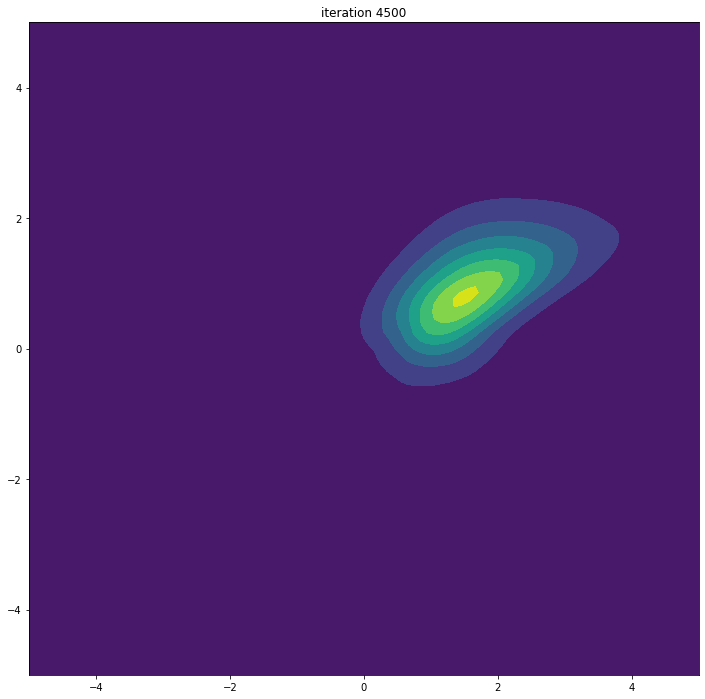

iteration: 4600, loss: tensor(0.0230, grad_fn=<MeanBackward0>)
iteration: 4700, loss: tensor(0.0250, grad_fn=<MeanBackward0>)
iteration: 4800, loss: tensor(0.0361, grad_fn=<MeanBackward0>)
iteration: 4900, loss: tensor(0.0238, grad_fn=<MeanBackward0>)
iteration: 5000, loss: tensor(0.0227, grad_fn=<MeanBackward0>)


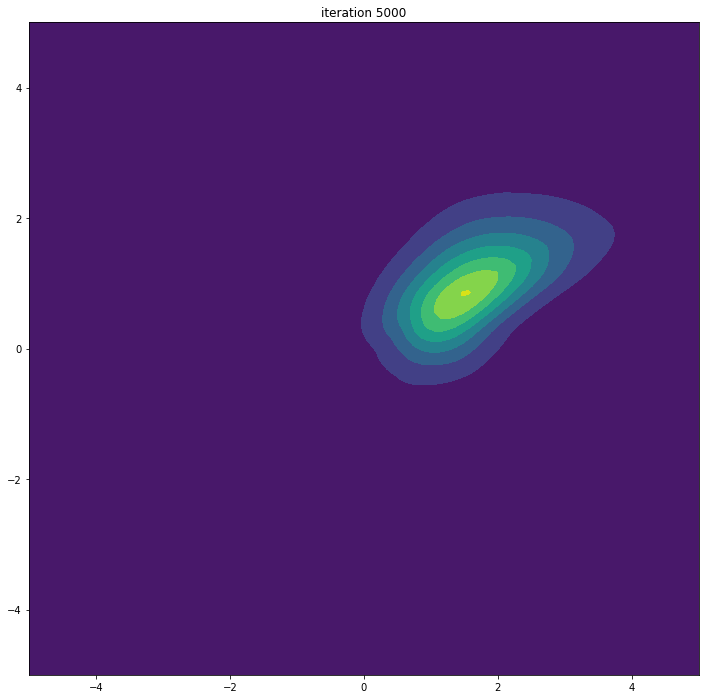

iteration: 5100, loss: tensor(0.0338, grad_fn=<MeanBackward0>)
iteration: 5200, loss: tensor(0.0299, grad_fn=<MeanBackward0>)
iteration: 5300, loss: tensor(0.0356, grad_fn=<MeanBackward0>)
iteration: 5400, loss: tensor(0.0435, grad_fn=<MeanBackward0>)
iteration: 5500, loss: tensor(0.0325, grad_fn=<MeanBackward0>)


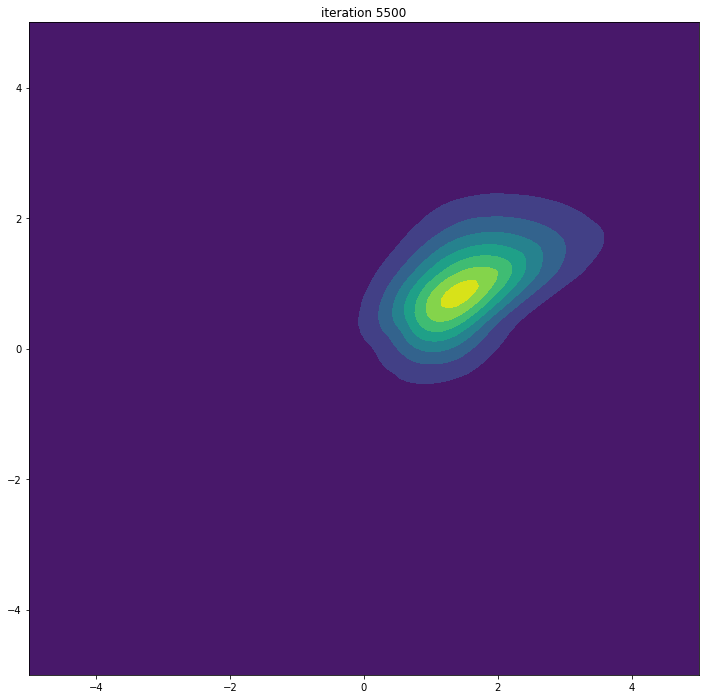

iteration: 5600, loss: tensor(0.0250, grad_fn=<MeanBackward0>)
iteration: 5700, loss: tensor(0.0366, grad_fn=<MeanBackward0>)
iteration: 5800, loss: tensor(0.0331, grad_fn=<MeanBackward0>)
iteration: 5900, loss: tensor(0.0259, grad_fn=<MeanBackward0>)
iteration: 6000, loss: tensor(0.0374, grad_fn=<MeanBackward0>)


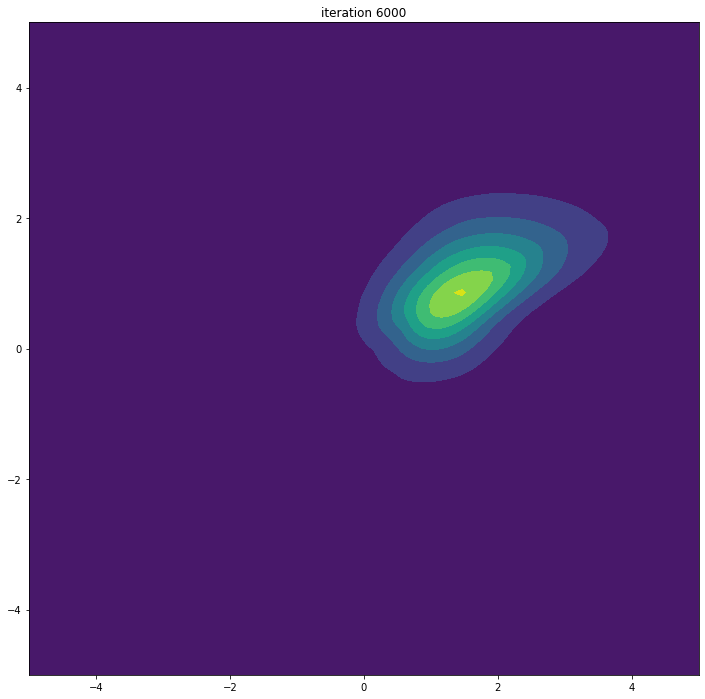

iteration: 6100, loss: tensor(0.0276, grad_fn=<MeanBackward0>)
iteration: 6200, loss: tensor(0.0378, grad_fn=<MeanBackward0>)
iteration: 6300, loss: tensor(0.0250, grad_fn=<MeanBackward0>)
iteration: 6400, loss: tensor(0.0349, grad_fn=<MeanBackward0>)
iteration: 6500, loss: tensor(0.0319, grad_fn=<MeanBackward0>)


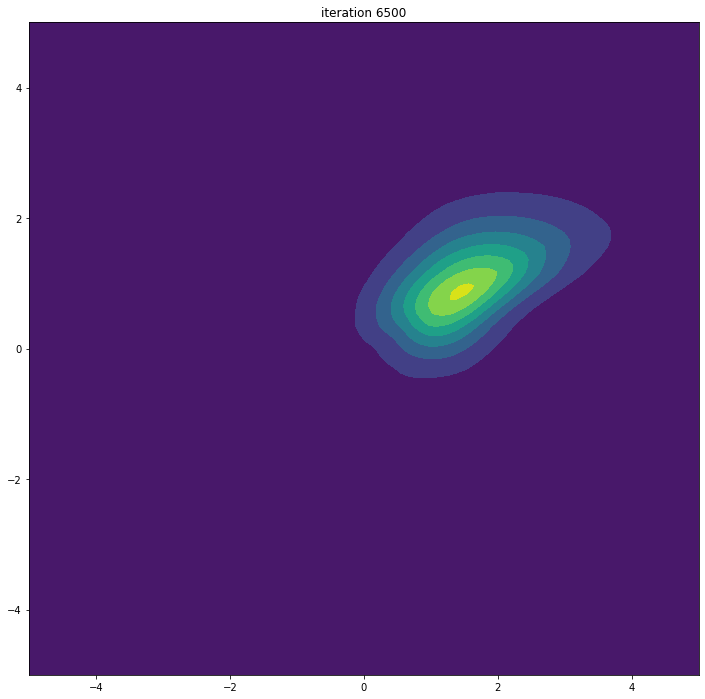

iteration: 6600, loss: tensor(0.0368, grad_fn=<MeanBackward0>)
iteration: 6700, loss: tensor(0.0295, grad_fn=<MeanBackward0>)
iteration: 6800, loss: tensor(0.0352, grad_fn=<MeanBackward0>)
iteration: 6900, loss: tensor(0.0396, grad_fn=<MeanBackward0>)
iteration: 7000, loss: tensor(0.0324, grad_fn=<MeanBackward0>)


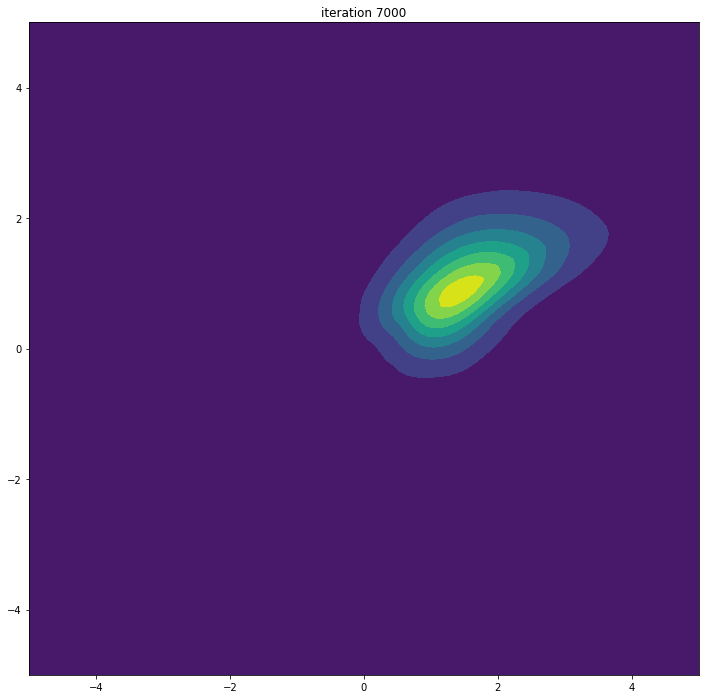

iteration: 7100, loss: tensor(0.0229, grad_fn=<MeanBackward0>)
iteration: 7200, loss: tensor(0.0347, grad_fn=<MeanBackward0>)
iteration: 7300, loss: tensor(0.0275, grad_fn=<MeanBackward0>)
iteration: 7400, loss: tensor(0.0333, grad_fn=<MeanBackward0>)
iteration: 7500, loss: tensor(0.0246, grad_fn=<MeanBackward0>)


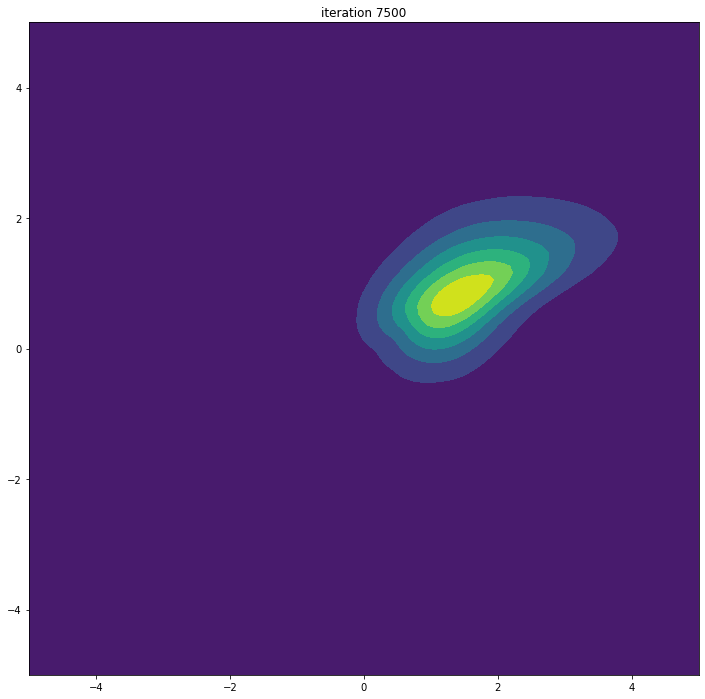

iteration: 7600, loss: tensor(0.0316, grad_fn=<MeanBackward0>)
iteration: 7700, loss: tensor(0.0390, grad_fn=<MeanBackward0>)
iteration: 7800, loss: tensor(0.0321, grad_fn=<MeanBackward0>)
iteration: 7900, loss: tensor(0.0365, grad_fn=<MeanBackward0>)
iteration: 8000, loss: tensor(0.0418, grad_fn=<MeanBackward0>)


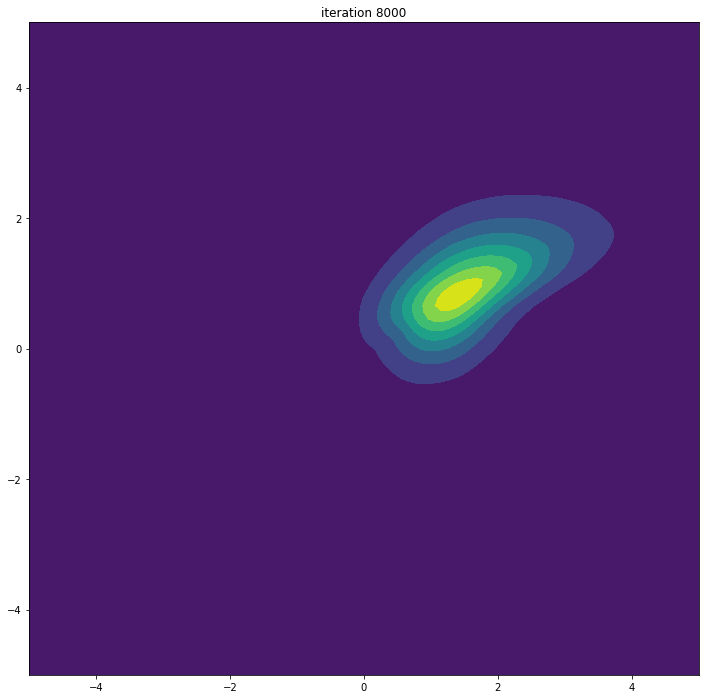

iteration: 8100, loss: tensor(0.0302, grad_fn=<MeanBackward0>)
iteration: 8200, loss: tensor(0.0281, grad_fn=<MeanBackward0>)
iteration: 8300, loss: tensor(0.0339, grad_fn=<MeanBackward0>)
iteration: 8400, loss: tensor(0.0304, grad_fn=<MeanBackward0>)
iteration: 8500, loss: tensor(0.0247, grad_fn=<MeanBackward0>)


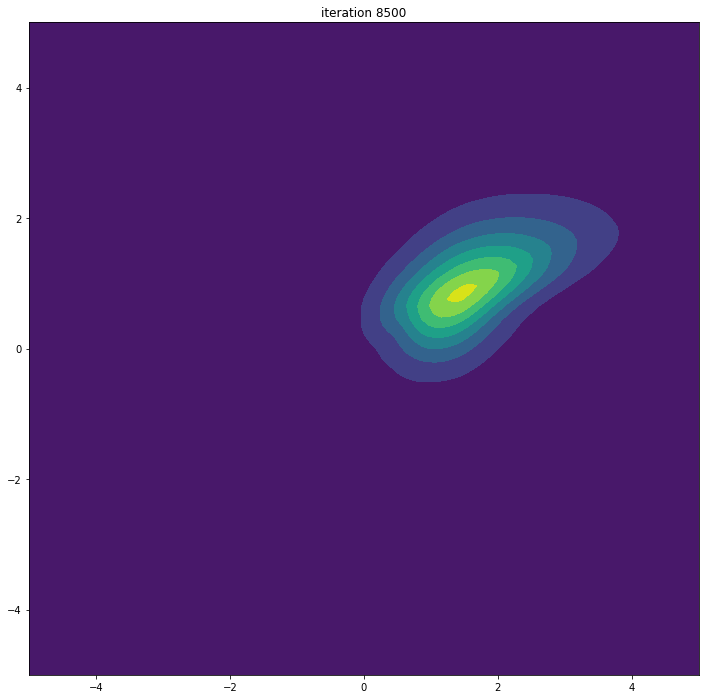

iteration: 8600, loss: tensor(0.0340, grad_fn=<MeanBackward0>)
iteration: 8700, loss: tensor(0.0266, grad_fn=<MeanBackward0>)
iteration: 8800, loss: tensor(0.0299, grad_fn=<MeanBackward0>)
iteration: 8900, loss: tensor(0.0276, grad_fn=<MeanBackward0>)
iteration: 9000, loss: tensor(0.0210, grad_fn=<MeanBackward0>)


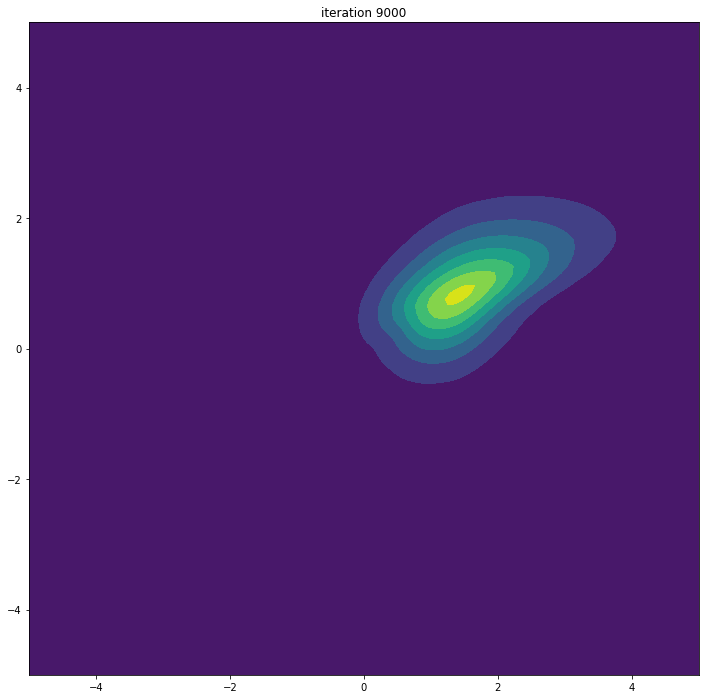

iteration: 9100, loss: tensor(0.0221, grad_fn=<MeanBackward0>)
iteration: 9200, loss: tensor(0.0343, grad_fn=<MeanBackward0>)
iteration: 9300, loss: tensor(0.0272, grad_fn=<MeanBackward0>)
iteration: 9400, loss: tensor(0.0424, grad_fn=<MeanBackward0>)
iteration: 9500, loss: tensor(0.0275, grad_fn=<MeanBackward0>)


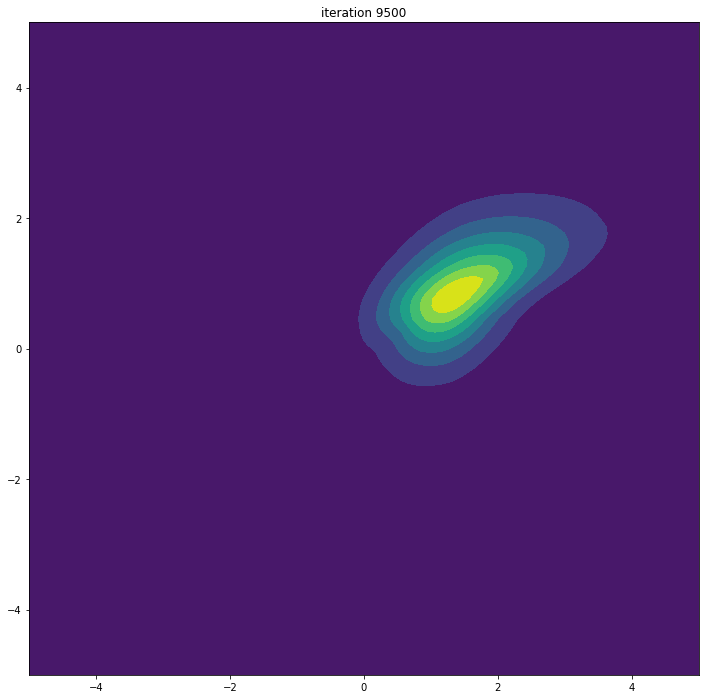

iteration: 9600, loss: tensor(0.0228, grad_fn=<MeanBackward0>)
iteration: 9700, loss: tensor(0.0265, grad_fn=<MeanBackward0>)
iteration: 9800, loss: tensor(0.0229, grad_fn=<MeanBackward0>)
iteration: 9900, loss: tensor(0.0234, grad_fn=<MeanBackward0>)
iteration: 10000, loss: tensor(0.0304, grad_fn=<MeanBackward0>)


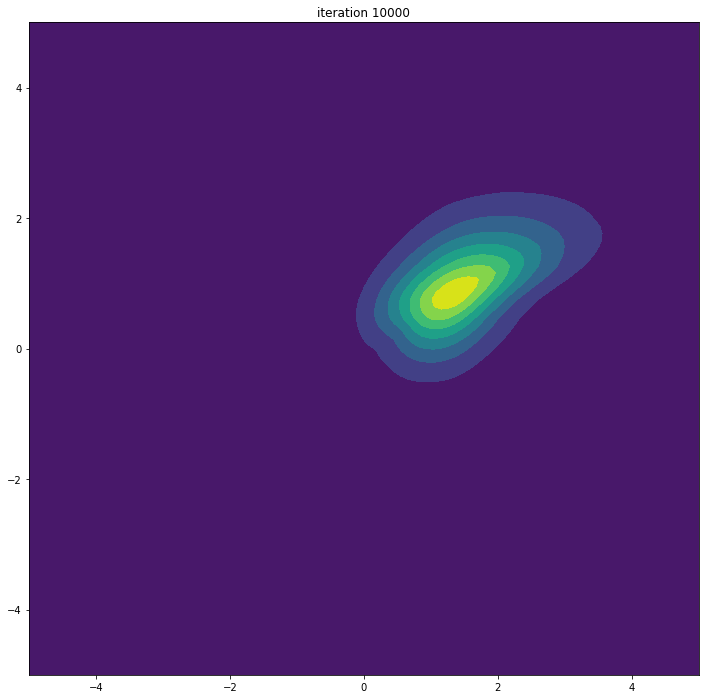

In [429]:
num_iter = 10000
for i in range(num_iter):
    N = 100
    x = base_dist.sample(N)

    optimizer.zero_grad()
    t_x = flow._transform(x)[0]

    loss = loss_KSD(t_x,score_mix)
    
    if (i + 1) % 100 == 0:
        print("iteration: " + str(i+1) + ", loss: " + str(loss))
    loss.backward()
    optimizer.step()
    
    if (i + 1) % 500 == 0:
        xline = torch.linspace(-5,5)
        yline = torch.linspace(-5,5)
        xgrid, ygrid = torch.meshgrid(xline, yline)
        xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

        with torch.no_grad():
            zgrid = flow.log_prob(xyinput).exp().reshape(100, 100)
        
        plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
        plt.title('iteration {}'.format(i + 1))
        plt.show()


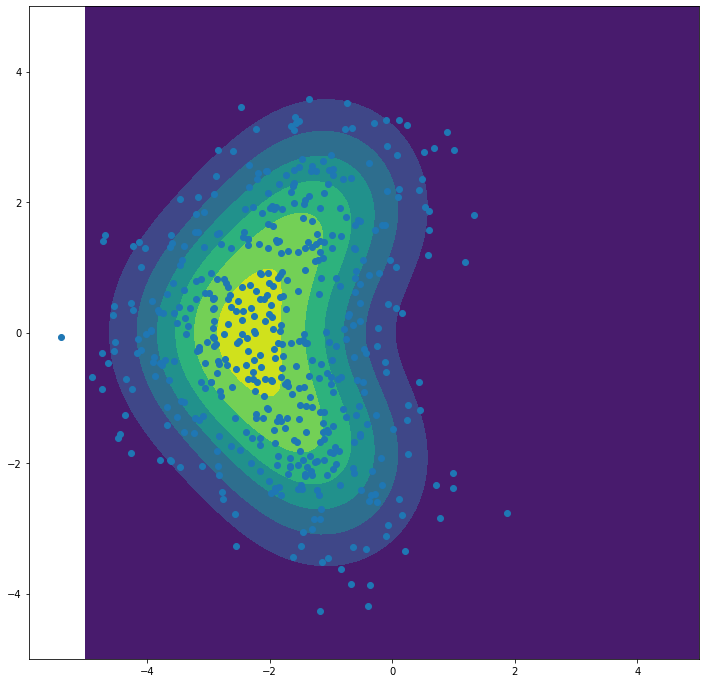

In [430]:
plot_MOG(MOG)

test = base_dist.sample(500)
t_test = flow._transform(test)[0]
t_test = t_test.detach().numpy()
plt.scatter(np.transpose(t_test)[0],np.transpose(t_test)[1])

plt.show()